# Modelos de Baseline sem BOX-COX

## Data

In [794]:
import pandas as pd
from pathlib import Path

path = Path("data_updated.csv")

df = pd.read_csv(path, parse_dates = True)

df["week"] = pd.to_datetime(df["week"])
df.head()

,week,volume,inv,users
0,2022-10-31,0.38,1.609882,6.500
1,2022-11-07,0.47,1.880548,7.061
2,2022-11-14,0.32,2.297810,5.875
3,2022-11-21,1.69,5.623875,24.238
4,2022-11-28,1.23,1.473418,7.648


### Spliting Data

In [795]:
# Célula: criar splits para Time-Series CV (rolling origin / expanding window)
import numpy as np

# parâmetros (ajuste conforme necessário)
initial_train = 120   # tamanho inicial da janela de treino (número de observações)
horizon = 4          # horizonte de previsão por fold
step = 1              # deslocamento entre folds

# garante ordenação temporal
df = df.sort_values("week").reset_index(drop=True)
series = df["volume"].astype(float).reset_index(drop=True)
n = len(series)

if initial_train + horizon > n:
    raise ValueError(f"Parâmetros inválidos: initial_train + horizon = {initial_train + horizon} > n ({n}). Reduza valores.")

# gera splits: cada item é (train_slice, test_slice) com slices python [start:stop)
cv_splits = []
for train_end in range(initial_train, n - horizon + 1, step):
    train_slice = slice(0, train_end)                       # treino: [0, train_end)
    test_slice = slice(train_end, train_end + horizon)      # teste: [train_end, train_end+horizon)
    cv_splits.append((train_slice, test_slice))

# resumo
print(f"Observações totais: {n}")
print(f"Folds gerados: {len(cv_splits)} (initial_train={initial_train}, horizon={horizon}, step={step})")
print("Exemplo dos 3 primeiros folds (indices start:stop):")
for i, (tr, te) in enumerate(cv_splits[:3], 1):
    print(f" Fold {i}: train {tr.start}:{tr.stop} -> test {te.start}:{te.stop}")


Observações totais: 157
Folds gerados: 34 (initial_train=120, horizon=4, step=1)
Exemplo dos 3 primeiros folds (indices start:stop):
 Fold 1: train 0:120 -> test 120:124
 Fold 2: train 0:121 -> test 121:125
 Fold 3: train 0:122 -> test 122:126


### Método da Média (Mean Method)

Este método assume que a melhor previsão para o futuro é simplesmente a média dos valores históricos observados até o momento. A previsão para $h$ períodos à frente ($T+h$) é dada por:

$\hat{y}_{T+h|T} = \bar{y} = \frac{y_1 + ... + y_T}{T}$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $\bar{y}$ é a média dos valores observados até o tempo $T$.
- $y_i$ é o valor observado no tempo $i$.
- $T$ é o número total de observações históricas.

Este método é eficaz quando a série temporal não apresenta uma tendência clara ou sazonalidade, e os valores futuros são esperados em torno da média histórica. É o baseline mais simples e serve para verificar se qualquer modelo mais complexo consegue superar a simples média histórica.

In [796]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

rows = []
for i, (tr_slice, te_slice) in enumerate(cv_splits, start=1):
    train = series.iloc[tr_slice].reset_index(drop=True)
    test = series.iloc[te_slice].reset_index(drop=True)
    h = len(test)
    
    # One-step-ahead rolling forecast
    preds = []
    for j in range(h):
        # Para cada ponto, usa todos os dados reais até aquele momento
        # history = treino + valores reais do teste até j-1
        if j == 0:
            history = train
        else:
            history = pd.concat([train, test.iloc[:j]], ignore_index=True)
        
        # Calcula a média de todo o histórico
        mu = history.mean()
        preds.append(mu)
    
    preds = np.array(preds)
    mae = mean_absolute_error(test, preds)
    rmse = np.sqrt(mean_squared_error(test, preds))
    denom = np.where(np.abs(test.values) < 1e-9, 1e-9, test.values)
    mape = np.mean(np.abs((test.values - preds) / denom)) * 100
    rows.append({
        "fold": i,
        "train_end_index": tr_slice.stop - 1,
        "train_size": len(train),
        "horizon": h,
        "mean_train": train.mean(),
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

res_mean = pd.DataFrame(rows)
# res_mean.to_csv("baseline_mean_folds.csv", index=False)
res_mean

,fold,train_end_index,train_size,horizon,mean_train,MAE,RMSE,MAPE
0,1,119,120,4,2.526833,5.669756,5.806769,67.944710
1,2,120,121,4,2.559339,5.553561,5.732237,66.754169
2,3,121,122,4,2.600984,5.518556,5.701556,66.211781
3,4,122,123,4,2.653821,5.276659,5.440369,64.998221
4,5,123,124,4,2.711613,5.092082,5.204659,64.127017
5,6,124,125,4,2.739360,5.554400,5.581256,66.328487
6,7,125,126,4,2.778571,5.493348,5.528296,65.674170
7,8,126,127,4,2.822126,5.260568,5.310705,64.266097
8,9,127,128,4,2.872344,5.474897,5.580564,64.627620
9,10,128,129,4,2.913566,5.745483,5.857758,65.344610


In [797]:
# agregados
agg = res_mean.agg({
    "MAE": ["mean","std"],
    "RMSE": ["mean","std"],
    "MAPE": ["mean","std"]
}).T
print("Resumo agregado (Mean Method):")
display(agg)

print("\nLinhas por fold:")
display(res_mean)


Resumo agregado (Mean Method):


,mean,std
MAE,8.655486,3.387206
RMSE,8.793149,3.454942
MAPE,69.886653,4.356549



Linhas por fold:


,fold,train_end_index,train_size,horizon,mean_train,MAE,RMSE,MAPE
0,1,119,120,4,2.526833,5.669756,5.806769,67.944710
1,2,120,121,4,2.559339,5.553561,5.732237,66.754169
2,3,121,122,4,2.600984,5.518556,5.701556,66.211781
3,4,122,123,4,2.653821,5.276659,5.440369,64.998221
4,5,123,124,4,2.711613,5.092082,5.204659,64.127017
5,6,124,125,4,2.739360,5.554400,5.581256,66.328487
6,7,125,126,4,2.778571,5.493348,5.528296,65.674170
7,8,126,127,4,2.822126,5.260568,5.310705,64.266097
8,9,127,128,4,2.872344,5.474897,5.580564,64.627620
9,10,128,129,4,2.913566,5.745483,5.857758,65.344610


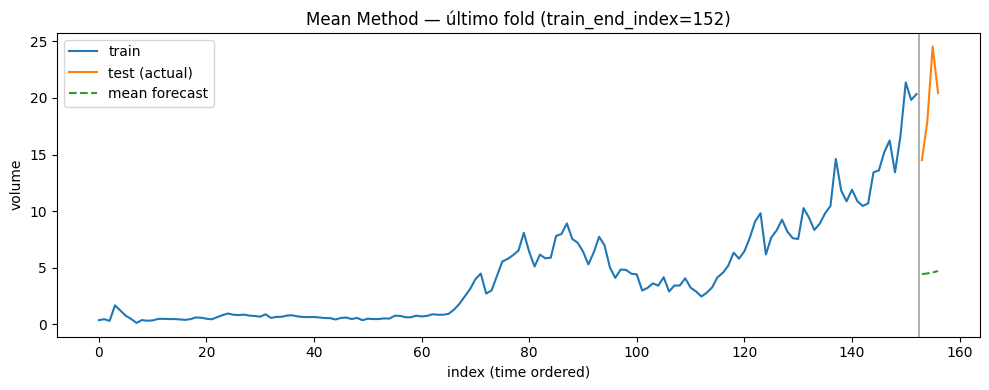

In [798]:
# Plot do último fold (visualização treino/teste/pred)
last = cv_splits[-1]
train = series.iloc[last[0]].reset_index(drop=True)
test = series.iloc[last[1]].reset_index(drop=True)
h = len(test)

# Recria one-step-ahead rolling forecast
preds = []
for j in range(h):
    if j == 0:
        history = train
    else:
        history = pd.concat([train, test.iloc[:j]], ignore_index=True)
    mu = history.mean()
    preds.append(mu)
preds = np.array(preds)

plt.figure(figsize=(10,4))
plt.plot(np.arange(len(train)), train, label="train", color="C0")
plt.plot(np.arange(len(train), len(train)+h), test, label="test (actual)", color="C1")
plt.plot(np.arange(len(train), len(train)+h), preds, label="mean forecast", color="C2", linestyle="--")
plt.axvline(len(train)-0.5, color="k", alpha=0.3)
plt.legend()
plt.title(f"Mean Method — último fold (train_end_index={last[0].stop-1})")
plt.xlabel("index (time ordered)")
plt.ylabel("volume")
plt.tight_layout()
plt.show()

In [799]:
# agregados
agg = res_mean.agg({
    "MAE": ["mean","std"],
    "RMSE": ["mean","std"],
    "MAPE": ["mean","std"]
}).T
print("Resumo agregado (Mean Method):")
display(agg)


Resumo agregado (Mean Method):


,mean,std
MAE,8.655486,3.387206
RMSE,8.793149,3.454942
MAPE,69.886653,4.356549


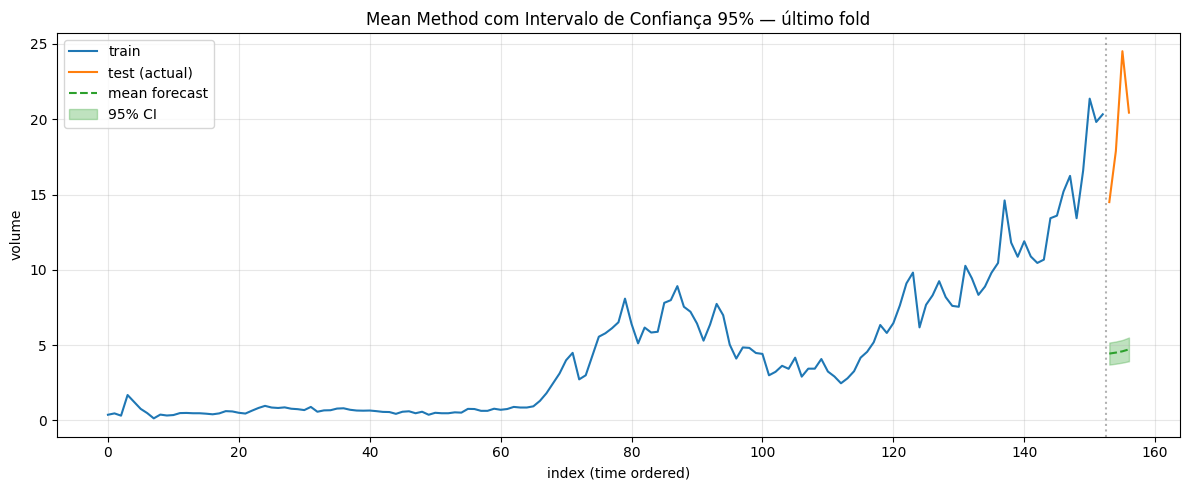

Intervalo de Confiança (95%) - one-step-ahead rolling forecast
  Primeira previsão: 4.44 [3.71, 5.17]
  Última previsão: 4.72 [3.93, 5.51]


In [800]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# último fold
last = cv_splits[-1]
train = series.iloc[last[0]].reset_index(drop=True)
test = series.iloc[last[1]].reset_index(drop=True)
h = len(test)

# Recria one-step-ahead rolling forecast com intervalos de confiança
preds = []
lower_bounds = []
upper_bounds = []

for j in range(h):
    if j == 0:
        history = train
    else:
        history = pd.concat([train, test.iloc[:j]], ignore_index=True)
    
    # previsão pontual (média)
    mu = history.mean()
    preds.append(mu)
    
    # intervalo de confiança: baseado no desvio padrão dos resíduos do histórico
    residuals = history - mu
    std_residuals = np.std(residuals, ddof=1)
    
    # margem de erro (95% de confiança)
    z_score = stats.norm.ppf(0.975)  # 1.96 para 95%
    margin_of_error = z_score * std_residuals / np.sqrt(len(history))
    
    lower_bounds.append(mu - margin_of_error)
    upper_bounds.append(mu + margin_of_error)

preds = np.array(preds)
lower = np.array(lower_bounds)
upper = np.array(upper_bounds)

# plot
fig, ax = plt.subplots(figsize=(12, 5))

# treino
train_idx = np.arange(len(train))
ax.plot(train_idx, train, label="train", color="C0", linewidth=1.5)

# teste + previsão + intervalo
test_idx = np.arange(len(train), len(train) + h)
ax.plot(test_idx, test, label="test (actual)", color="C1", linewidth=1.5)
ax.plot(test_idx, preds, label="mean forecast", color="C2", linestyle="--", linewidth=1.5)
ax.fill_between(test_idx, lower, upper, alpha=0.3, color="C2", label="95% CI")

# separador treino/teste
ax.axvline(len(train) - 0.5, color="k", alpha=0.3, linestyle=":")

ax.legend()
ax.set_title(f"Mean Method com Intervalo de Confiança 95% — último fold")
ax.set_xlabel("index (time ordered)")
ax.set_ylabel("volume")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Intervalo de Confiança (95%) - one-step-ahead rolling forecast")
print(f"  Primeira previsão: {preds[0]:.2f} [{lower[0]:.2f}, {upper[0]:.2f}]")
print(f"  Última previsão: {preds[-1]:.2f} [{lower[-1]:.2f}, {upper[-1]:.2f}]")

In [801]:
import numpy as np

alpha = 0.05  # nível de significância (IC 95%)

# cobertura e taxa de violação
coverage = np.sum((test >= lower) & (test <= upper)) / len(test) * 100
violation_rate = 100 - coverage

# largura média do intervalo
avg_width = np.mean(upper - lower)
train_range = train.max() - train.min()
pinaw = avg_width / train_range * 100

# Winkler Score (penaliza largura + violações)
# Fórmula: 
#   se y_t in [L_t, U_t]: W_t = U_t - L_t
#   se y_t < L_t:         W_t = U_t - L_t + 2/alpha * (L_t - y_t)
#   se y_t > U_t:         W_t = U_t - L_t + 2/alpha * (y_t - U_t)

winkler_scores = []
for i, y_t in enumerate(test):
    width = upper[i] - lower[i]
    if y_t < lower[i]:
        ws = width + (2 / alpha) * (lower[i] - y_t)
    elif y_t > upper[i]:
        ws = width + (2 / alpha) * (y_t - upper[i])
    else:
        ws = width
    winkler_scores.append(ws)

mean_winkler = np.mean(winkler_scores)

print("=" * 60)
print("MÉTRICAS DO INTERVALO DE CONFIANÇA (95%)")
print("One-step-ahead rolling forecast")
print("=" * 60)
print(f"\n1. Cobertura (Coverage):")
print(f"   {coverage:.2f}% (ideal: ~95%)")

print(f"\n2. Taxa de Violação:")
print(f"   {violation_rate:.2f}% (ideal: ~5%)")

print(f"\n3. Largura média do intervalo:")
print(f"   {avg_width:.4f}")

print(f"\n4. PINAW (normalizado pelo range de treino):")
print(f"   {pinaw:.2f}% (menor = intervalo mais estreito)")

print(f"\n5. Winkler Score (média):")
print(f"   {mean_winkler:.4f}")
print(f"   (Menor é melhor: combina largura + penalidade por violações)")

MÉTRICAS DO INTERVALO DE CONFIANÇA (95%)
One-step-ahead rolling forecast

1. Cobertura (Coverage):
   0.00% (ideal: ~95%)

2. Taxa de Violação:
   100.00% (ideal: ~5%)

3. Largura média do intervalo:
   1.5050

4. PINAW (normalizado pelo range de treino):
   7.09% (menor = intervalo mais estreito)

5. Winkler Score (média):
   562.3076
   (Menor é melhor: combina largura + penalidade por violações)


### Método Ingênuo ou Passeio Aleatório sem Tendência (Naive or Random Walk with No Drift)

Neste método, a previsão para o próximo período é simplesmente o último valor observado. Este método é conhecido como “ingênuo” porque assume que as mudanças futuras serão iguais às últimas observações, ou seja, que não temos nenhum insight sistemático sobre os valores futuros além do valor mais recente. A previsão para $h$ períodos à frente é dada por:

$\hat{y}_{T+h|T} = y_T$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $y_T$ é o último valor observado no tempo $T$.

Este baseline é muito útil para séries que se assemelham a um passeio aleatório. Se um modelo não consegue superar o método ingênuo, isso pode indicar que a série é muito volátil ou que o modelo não está capturando adequadamente a estrutura de dependência temporal de curto prazo.

In [802]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

rows = []
for i, (tr_slice, te_slice) in enumerate(cv_splits, start=1):
    train = series.iloc[tr_slice].reset_index(drop=True)
    test = series.iloc[te_slice].reset_index(drop=True)
    h = len(test)
    
    # One-step-ahead rolling forecast
    preds = []
    for j in range(h):
        # Para cada ponto, usa o último valor real observado
        if j == 0:
            # Primeira previsão: usa o último valor do treino
            last_value = train.iloc[-1]
        else:
            # Próximas previsões: usa o último valor real do teste
            last_value = test.iloc[j-1]
        preds.append(last_value)
    
    preds = np.array(preds)
    mae = mean_absolute_error(test, preds)
    rmse = np.sqrt(mean_squared_error(test, preds))
    denom = np.where(np.abs(test.values) < 1e-9, 1e-9, test.values)
    mape = np.mean(np.abs((test.values - preds) / denom)) * 100
    rows.append({
        "fold": i,
        "train_end_index": tr_slice.stop - 1,
        "train_size": len(train),
        "horizon": h,
        "last_value": train.iloc[-1],
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

res_naive = pd.DataFrame(rows)
# res_naive.to_csv("baseline_naive_folds.csv", index=False)
res_naive

,fold,train_end_index,train_size,horizon,last_value,MAE,RMSE,MAPE
0,1,119,120,4,5.81,1.0025,1.056515,12.220719
1,2,120,121,4,6.46,1.7500,2.079183,24.430159
2,3,121,122,4,7.64,1.8300,2.130117,25.451714
3,4,122,123,4,9.10,1.6225,2.025765,23.336032
4,5,123,124,4,9.82,1.6775,2.048176,24.043579
5,6,124,125,4,6.18,1.0325,1.078668,12.554313
6,7,125,126,4,7.68,0.8025,0.827723,9.576888
7,8,126,127,4,8.31,0.6600,0.766029,7.880257
8,9,127,128,4,9.25,1.1050,1.488456,11.960943
9,10,128,129,4,8.19,1.0475,1.451491,10.923383


In [803]:
# agregados
agg = res_naive.agg({
    "MAE": ["mean","std"],
    "RMSE": ["mean","std"],
    "MAPE": ["mean","std"]
}).T
print("Resumo agregado (Naive Method):")
display(agg)

print("\nLinhas por fold:")
display(res_naive)

Resumo agregado (Naive Method):


,mean,std
MAE,1.747206,1.009968
RMSE,2.053144,1.105658
MAPE,14.308747,5.787623



Linhas por fold:


,fold,train_end_index,train_size,horizon,last_value,MAE,RMSE,MAPE
0,1,119,120,4,5.81,1.0025,1.056515,12.220719
1,2,120,121,4,6.46,1.7500,2.079183,24.430159
2,3,121,122,4,7.64,1.8300,2.130117,25.451714
3,4,122,123,4,9.10,1.6225,2.025765,23.336032
4,5,123,124,4,9.82,1.6775,2.048176,24.043579
5,6,124,125,4,6.18,1.0325,1.078668,12.554313
6,7,125,126,4,7.68,0.8025,0.827723,9.576888
7,8,126,127,4,8.31,0.6600,0.766029,7.880257
8,9,127,128,4,9.25,1.1050,1.488456,11.960943
9,10,128,129,4,8.19,1.0475,1.451491,10.923383


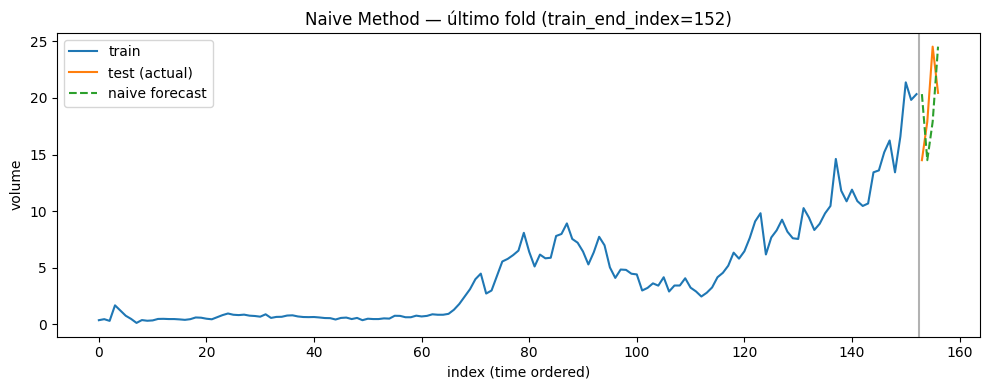

In [804]:
# Plot do último fold (visualização treino/teste/pred)
last = cv_splits[-1]
train = series.iloc[last[0]].reset_index(drop=True)
test = series.iloc[last[1]].reset_index(drop=True)
h = len(test)

# Recria one-step-ahead rolling forecast
preds = []
for j in range(h):
    if j == 0:
        last_value = train.iloc[-1]
    else:
        last_value = test.iloc[j-1]
    preds.append(last_value)
preds = np.array(preds)

plt.figure(figsize=(10,4))
plt.plot(np.arange(len(train)), train, label="train", color="C0")
plt.plot(np.arange(len(train), len(train)+h), test, label="test (actual)", color="C1")
plt.plot(np.arange(len(train), len(train)+h), preds, label="naive forecast", color="C2", linestyle="--")
plt.axvline(len(train)-0.5, color="k", alpha=0.3)
plt.legend()
plt.title(f"Naive Method — último fold (train_end_index={last[0].stop-1})")
plt.xlabel("index (time ordered)")
plt.ylabel("volume")
plt.tight_layout()
plt.show()

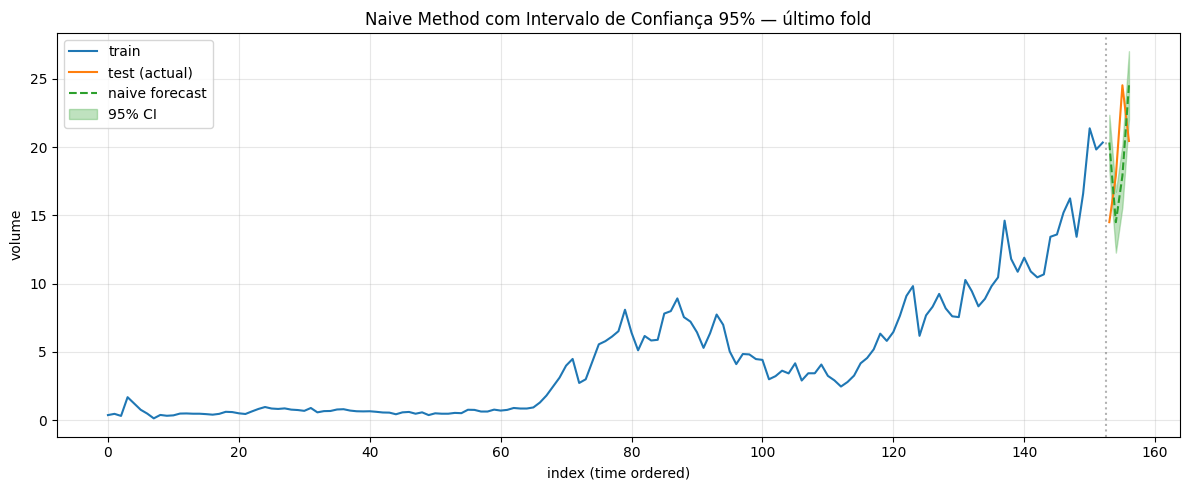

Intervalo de Confiança (95%) - one-step-ahead rolling forecast
  Primeira previsão: 20.33 [18.31, 22.35]
  Última previsão: 24.52 [22.03, 27.01]


In [805]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# último fold
last = cv_splits[-1]
train = series.iloc[last[0]].reset_index(drop=True)
test = series.iloc[last[1]].reset_index(drop=True)
h = len(test)

# Recria one-step-ahead rolling forecast com intervalos de confiança
preds = []
lower_bounds = []
upper_bounds = []

for j in range(h):
    if j == 0:
        history = train
    else:
        history = pd.concat([train, test.iloc[:j]], ignore_index=True)
    
    # previsão pontual (último valor)
    last_value = history.iloc[-1]
    preds.append(last_value)
    
    # intervalo de confiança: baseado no desvio padrão das diferenças consecutivas
    # Para Naive, usamos a variância das primeiras diferenças
    diffs = history.diff().dropna()
    std_diffs = np.std(diffs, ddof=1)
    
    # margem de erro (95% de confiança) para 1-step-ahead
    z_score = stats.norm.ppf(0.975)  # 1.96 para 95%
    margin_of_error = z_score * std_diffs
    
    lower_bounds.append(last_value - margin_of_error)
    upper_bounds.append(last_value + margin_of_error)

preds = np.array(preds)
lower = np.array(lower_bounds)
upper = np.array(upper_bounds)

# plot
fig, ax = plt.subplots(figsize=(12, 5))

# treino
train_idx = np.arange(len(train))
ax.plot(train_idx, train, label="train", color="C0", linewidth=1.5)

# teste + previsão + intervalo
test_idx = np.arange(len(train), len(train) + h)
ax.plot(test_idx, test, label="test (actual)", color="C1", linewidth=1.5)
ax.plot(test_idx, preds, label="naive forecast", color="C2", linestyle="--", linewidth=1.5)
ax.fill_between(test_idx, lower, upper, alpha=0.3, color="C2", label="95% CI")

# separador treino/teste
ax.axvline(len(train) - 0.5, color="k", alpha=0.3, linestyle=":")

ax.legend()
ax.set_title(f"Naive Method com Intervalo de Confiança 95% — último fold")
ax.set_xlabel("index (time ordered)")
ax.set_ylabel("volume")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Intervalo de Confiança (95%) - one-step-ahead rolling forecast")
print(f"  Primeira previsão: {preds[0]:.2f} [{lower[0]:.2f}, {upper[0]:.2f}]")
print(f"  Última previsão: {preds[-1]:.2f} [{lower[-1]:.2f}, {upper[-1]:.2f}]")

In [806]:
import numpy as np

alpha = 0.05  # nível de significância (IC 95%)

# cobertura e taxa de violação
coverage = np.sum((test >= lower) & (test <= upper)) / len(test) * 100
violation_rate = 100 - coverage

# largura média do intervalo
avg_width = np.mean(upper - lower)
train_range = train.max() - train.min()
pinaw = avg_width / train_range * 100

# Winkler Score (penaliza largura + violações)
winkler_scores = []
for i, y_t in enumerate(test):
    width = upper[i] - lower[i]
    if y_t < lower[i]:
        ws = width + (2 / alpha) * (lower[i] - y_t)
    elif y_t > upper[i]:
        ws = width + (2 / alpha) * (y_t - upper[i])
    else:
        ws = width
    winkler_scores.append(ws)

mean_winkler = np.mean(winkler_scores)

print("=" * 60)
print("MÉTRICAS DO INTERVALO DE CONFIANÇA (95%) - NAIVE METHOD")
print("One-step-ahead rolling forecast")
print("=" * 60)
print(f"\n1. Cobertura (Coverage):")
print(f"   {coverage:.2f}% (ideal: ~95%)")

print(f"\n2. Taxa de Violação:")
print(f"   {violation_rate:.2f}% (ideal: ~5%)")

print(f"\n3. Largura média do intervalo:")
print(f"   {avg_width:.4f}")

print(f"\n4. PINAW (normalizado pelo range de treino):")
print(f"   {pinaw:.2f}% (menor = intervalo mais estreito)")

print(f"\n5. Winkler Score (média):")
print(f"   {mean_winkler:.4f}")
print(f"   (Menor é melhor: combina largura + penalidade por violações)")

MÉTRICAS DO INTERVALO DE CONFIANÇA (95%) - NAIVE METHOD
One-step-ahead rolling forecast

1. Cobertura (Coverage):
   0.00% (ideal: ~95%)

2. Taxa de Violação:
   100.00% (ideal: ~5%)

3. Largura média do intervalo:
   4.5130

4. PINAW (normalizado pelo range de treino):
   21.26% (menor = intervalo mais estreito)

5. Winkler Score (média):
   113.5524
   (Menor é melhor: combina largura + penalidade por violações)


### Método Sazonal Ingênuo (Seasonal Naive)

Este método é uma variação do método ingênuo, especialmente útil para séries com forte sazonalidade conhecida. Ele prevê o valor para um período futuro usando o valor observado no mesmo período sazonal do ciclo anterior.

A previsão para o período $T+h$ é dada por:

$\hat{y}_{T+h|T} = y_{T+h-m}$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $y_{T+h-m}$ é o valor observado no mesmo período sazonal ($m$) do ciclo anterior mais recente disponível nos dados históricos.
- $m$ é o período da sazonalidade (por exemplo, $m=12$ para dados mensais com sazonalidade anual, $m=52$ para dados semanais com sazonalidade anual).

Este baseline é um forte concorrente para séries com padrões sazonais consistentes. Se um modelo não superar o Seasonal Naive para uma série sazonal, ele pode não estar capturando bem o componente sazonal.

In [807]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Período de sazonalidade (52 semanas = 1 ano)
m = 52

rows = []
for i, (tr_slice, te_slice) in enumerate(cv_splits, start=1):
    train = series.iloc[tr_slice].reset_index(drop=True)
    test = series.iloc[te_slice].reset_index(drop=True)
    h = len(test)
    
    # One-step-ahead rolling forecast
    preds = []
    for j in range(h):
        # Para cada ponto, usa todos os dados reais até aquele momento
        if j == 0:
            history = train
        else:
            history = pd.concat([train, test.iloc[:j]], ignore_index=True)
        
        # Usa o valor de m períodos atrás
        seasonal_idx = len(history) - m
        if seasonal_idx >= 0:
            pred = history.iloc[seasonal_idx]
        else:
            # Fallback: usa o último valor
            pred = history.iloc[-1]
        preds.append(pred)
    
    preds = np.array(preds)
    mae = mean_absolute_error(test, preds)
    rmse = np.sqrt(mean_squared_error(test, preds))
    denom = np.where(np.abs(test.values) < 1e-9, 1e-9, test.values)
    mape = np.mean(np.abs((test.values - preds) / denom)) * 100
    rows.append({
        "fold": i,
        "train_end_index": tr_slice.stop - 1,
        "train_size": len(train),
        "horizon": h,
        "seasonal_lag": m,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

res_seasonal_naive = pd.DataFrame(rows)
# res_seasonal_naive.to_csv("baseline_seasonal_naive_folds.csv", index=False)
res_seasonal_naive

,fold,train_end_index,train_size,horizon,seasonal_lag,MAE,RMSE,MAPE
0,1,119,120,4,52,4.7350,4.763649,57.811988
1,2,120,121,4,52,4.6000,4.657032,56.327122
2,3,121,122,4,52,4.6400,4.696376,56.770921
3,4,122,123,4,52,4.3725,4.428733,54.883879
4,5,123,124,4,52,3.9625,3.989420,51.287606
5,6,124,125,4,52,3.7000,3.792077,44.657302
6,7,125,126,4,52,2.9025,3.075593,34.317803
7,8,126,127,4,52,2.1525,2.379974,25.604451
8,9,127,128,4,52,1.7750,1.856973,20.938197
9,10,128,129,4,52,1.9325,2.074506,21.636554


In [808]:
# agregados
agg = res_seasonal_naive.agg({
    "MAE": ["mean","std"],
    "RMSE": ["mean","std"],
    "MAPE": ["mean","std"]
}).T
print("Resumo agregado (Seasonal Naive Method):")
display(agg)

print("\nLinhas por fold:")
display(res_seasonal_naive)

Resumo agregado (Seasonal Naive Method):


,mean,std
MAE,6.507206,4.512712
RMSE,6.658787,4.558648
MAPE,49.048764,18.448099



Linhas por fold:


,fold,train_end_index,train_size,horizon,seasonal_lag,MAE,RMSE,MAPE
0,1,119,120,4,52,4.7350,4.763649,57.811988
1,2,120,121,4,52,4.6000,4.657032,56.327122
2,3,121,122,4,52,4.6400,4.696376,56.770921
3,4,122,123,4,52,4.3725,4.428733,54.883879
4,5,123,124,4,52,3.9625,3.989420,51.287606
5,6,124,125,4,52,3.7000,3.792077,44.657302
6,7,125,126,4,52,2.9025,3.075593,34.317803
7,8,126,127,4,52,2.1525,2.379974,25.604451
8,9,127,128,4,52,1.7750,1.856973,20.938197
9,10,128,129,4,52,1.9325,2.074506,21.636554


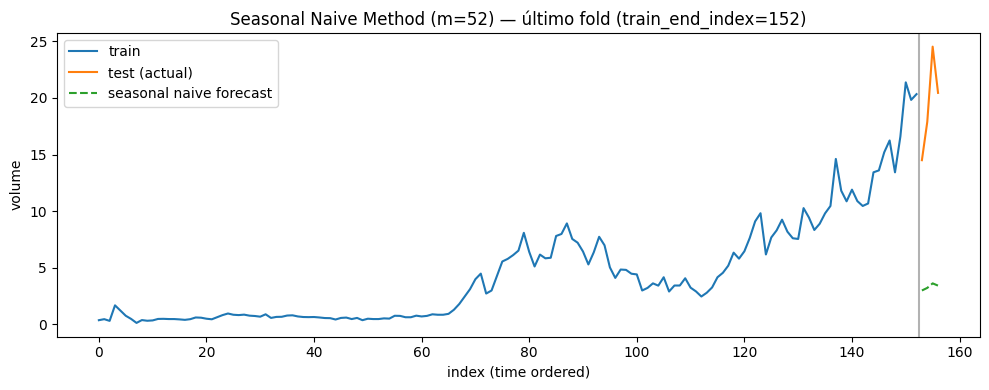

In [809]:
# Plot do último fold (visualização treino/teste/pred)
last = cv_splits[-1]
train = series.iloc[last[0]].reset_index(drop=True)
test = series.iloc[last[1]].reset_index(drop=True)
h = len(test)

# Recria one-step-ahead rolling forecast
preds = []
for j in range(h):
    if j == 0:
        history = train
    else:
        history = pd.concat([train, test.iloc[:j]], ignore_index=True)
    
    seasonal_idx = len(history) - m
    if seasonal_idx >= 0:
        pred = history.iloc[seasonal_idx]
    else:
        pred = history.iloc[-1]
    preds.append(pred)
preds = np.array(preds)

plt.figure(figsize=(10,4))
plt.plot(np.arange(len(train)), train, label="train", color="C0")
plt.plot(np.arange(len(train), len(train)+h), test, label="test (actual)", color="C1")
plt.plot(np.arange(len(train), len(train)+h), preds, label="seasonal naive forecast", color="C2", linestyle="--")
plt.axvline(len(train)-0.5, color="k", alpha=0.3)
plt.legend()
plt.title(f"Seasonal Naive Method (m={m}) — último fold (train_end_index={last[0].stop-1})")
plt.xlabel("index (time ordered)")
plt.ylabel("volume")
plt.tight_layout()
plt.show()

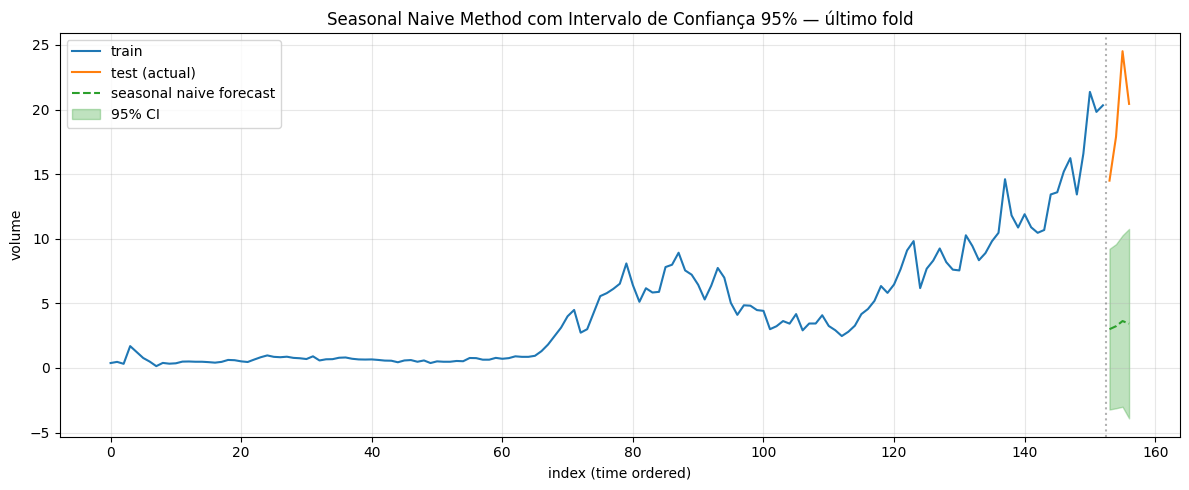

Intervalo de Confiança (95%) - one-step-ahead rolling forecast
  Primeira previsão: 3.00 [-3.22, 9.22]
  Última previsão: 3.43 [-3.90, 10.76]


In [810]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# último fold
last = cv_splits[-1]
train = series.iloc[last[0]].reset_index(drop=True)
test = series.iloc[last[1]].reset_index(drop=True)
h = len(test)

# Recria one-step-ahead rolling forecast com intervalos de confiança
preds = []
lower_bounds = []
upper_bounds = []

for j in range(h):
    if j == 0:
        history = train
    else:
        history = pd.concat([train, test.iloc[:j]], ignore_index=True)
    
    # previsão pontual (valor sazonal)
    seasonal_idx = len(history) - m
    if seasonal_idx >= 0:
        pred = history.iloc[seasonal_idx]
    else:
        pred = history.iloc[-1]
    preds.append(pred)
    
    # intervalo de confiança: baseado no desvio padrão das diferenças sazonais
    # Para Seasonal Naive, usamos a variância das diferenças sazonais
    if len(history) >= m + 1:
        seasonal_diffs = []
        for k in range(m, len(history)):
            seasonal_diffs.append(history.iloc[k] - history.iloc[k - m])
        if len(seasonal_diffs) > 1:
            std_seasonal = np.std(seasonal_diffs, ddof=1)
        else:
            std_seasonal = np.std(history, ddof=1)
    else:
        std_seasonal = np.std(history, ddof=1)
    
    # margem de erro (95% de confiança)
    z_score = stats.norm.ppf(0.975)  # 1.96 para 95%
    margin_of_error = z_score * std_seasonal
    
    lower_bounds.append(pred - margin_of_error)
    upper_bounds.append(pred + margin_of_error)

preds = np.array(preds)
lower = np.array(lower_bounds)
upper = np.array(upper_bounds)

# plot
fig, ax = plt.subplots(figsize=(12, 5))

# treino
train_idx = np.arange(len(train))
ax.plot(train_idx, train, label="train", color="C0", linewidth=1.5)

# teste + previsão + intervalo
test_idx = np.arange(len(train), len(train) + h)
ax.plot(test_idx, test, label="test (actual)", color="C1", linewidth=1.5)
ax.plot(test_idx, preds, label="seasonal naive forecast", color="C2", linestyle="--", linewidth=1.5)
ax.fill_between(test_idx, lower, upper, alpha=0.3, color="C2", label="95% CI")

# separador treino/teste
ax.axvline(len(train) - 0.5, color="k", alpha=0.3, linestyle=":")

ax.legend()
ax.set_title(f"Seasonal Naive Method com Intervalo de Confiança 95% — último fold")
ax.set_xlabel("index (time ordered)")
ax.set_ylabel("volume")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Intervalo de Confiança (95%) - one-step-ahead rolling forecast")
print(f"  Primeira previsão: {preds[0]:.2f} [{lower[0]:.2f}, {upper[0]:.2f}]")
print(f"  Última previsão: {preds[-1]:.2f} [{lower[-1]:.2f}, {upper[-1]:.2f}]")

In [811]:
import numpy as np

alpha = 0.05  # nível de significância (IC 95%)

# cobertura e taxa de violação
coverage = np.sum((test >= lower) & (test <= upper)) / len(test) * 100
violation_rate = 100 - coverage

# largura média do intervalo
avg_width = np.mean(upper - lower)
train_range = train.max() - train.min()
pinaw = avg_width / train_range * 100

# Winkler Score (penaliza largura + violações)
winkler_scores = []
for i, y_t in enumerate(test):
    width = upper[i] - lower[i]
    if y_t < lower[i]:
        ws = width + (2 / alpha) * (lower[i] - y_t)
    elif y_t > upper[i]:
        ws = width + (2 / alpha) * (y_t - upper[i])
    else:
        ws = width
    winkler_scores.append(ws)

mean_winkler = np.mean(winkler_scores)

print("=" * 60)
print("MÉTRICAS DO INTERVALO DE CONFIANÇA (95%) - SEASONAL NAIVE")
print("One-step-ahead rolling forecast")
print("=" * 60)
print(f"\n1. Cobertura (Coverage):")
print(f"   {coverage:.2f}% (ideal: ~95%)")

print(f"\n2. Taxa de Violação:")
print(f"   {violation_rate:.2f}% (ideal: ~5%)")

print(f"\n3. Largura média do intervalo:")
print(f"   {avg_width:.4f}")

print(f"\n4. PINAW (normalizado pelo range de treino):")
print(f"   {pinaw:.2f}% (menor = intervalo mais estreito)")

print(f"\n5. Winkler Score (média):")
print(f"   {mean_winkler:.4f}")
print(f"   (Menor é melhor: combina largura + penalidade por violações)")

MÉTRICAS DO INTERVALO DE CONFIANÇA (95%) - SEASONAL NAIVE
One-step-ahead rolling forecast

1. Cobertura (Coverage):
   0.00% (ideal: ~95%)

2. Taxa de Violação:
   100.00% (ideal: ~5%)

3. Largura média do intervalo:
   13.2682

4. PINAW (normalizado pelo range de treino):
   62.50% (menor = intervalo mais estreito)

5. Winkler Score (média):
   388.5033
   (Menor é melhor: combina largura + penalidade por violações)


### Método do Desvio (Drift Method)

O método do desvio é utilizado para séries temporais que seguem uma tendência linear ao longo do tempo. Este método assume que a diferença média entre observações consecutivas é constante, resultando em uma previsão que extrapola essa tendência:

$y_t = C + y_{t−1} + \epsilon_t$

A previsão para $h$ períodos à frente é dada por:

$\hat{y}_{T+h|T} = y_T + h \cdot C$

Onde $C$ representa o desvio médio entre as observações no período de treino:

$C = \frac{\sum_{t=2}^T (y_t − y_{t−1})}{T − 1} = \frac{y_T − y_1}{T − 1}$

Portanto, a previsão pode ser reescrita como:

$\hat{y}_{T+h|T} = y_T + h \left( \frac{y_T − y_1}{T − 1} \right)$

Este método é útil para séries que apresentam uma tendência consistente ao longo do tempo, como crescimento linear. Ele é mais robusto que o Método Ingênuo para séries com tendência, pois incorpora essa inclinação média na previsão.

In [812]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

rows = []
for i, (tr_slice, te_slice) in enumerate(cv_splits, start=1):
    train = series.iloc[tr_slice].reset_index(drop=True)
    test = series.iloc[te_slice].reset_index(drop=True)
    h = len(test)
    
    # One-step-ahead rolling forecast
    preds = []
    for j in range(h):
        # Para cada ponto, usa todos os dados reais até aquele momento
        if j == 0:
            history = train
        else:
            history = pd.concat([train, test.iloc[:j]], ignore_index=True)
        
        # Calcula o drift usando todo o histórico
        y_T = history.iloc[-1]
        y_1 = history.iloc[0]
        T = len(history)
        C = (y_T - y_1) / (T - 1)
        
        # Previsão: último valor + drift
        pred = y_T + C
        preds.append(pred)
    
    preds = np.array(preds)
    mae = mean_absolute_error(test, preds)
    rmse = np.sqrt(mean_squared_error(test, preds))
    denom = np.where(np.abs(test.values) < 1e-9, 1e-9, test.values)
    mape = np.mean(np.abs((test.values - preds) / denom)) * 100
    rows.append({
        "fold": i,
        "train_end_index": tr_slice.stop - 1,
        "train_size": len(train),
        "horizon": h,
        "drift_C": (train.iloc[-1] - train.iloc[0]) / (len(train) - 1),
        "y_T": train.iloc[-1],
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

res_drift = pd.DataFrame(rows)
# res_drift.to_csv("baseline_drift_folds.csv", index=False)
res_drift

,fold,train_end_index,train_size,horizon,drift_C,y_T,MAE,RMSE,MAPE
0,1,119,120,4,0.045630,5.81,0.945557,1.002652,11.531539
1,2,120,121,4,0.050667,6.46,1.723651,2.089868,24.228035
2,3,121,122,4,0.060000,7.64,1.804625,2.139314,25.263125
3,4,122,123,4,0.071475,9.10,1.597525,2.041653,23.136586
4,5,123,124,4,0.076748,9.82,1.654659,2.062889,23.855998
5,6,124,125,4,0.046774,6.18,1.007933,1.058817,12.269457
6,7,125,126,4,0.058400,7.68,0.804880,0.834178,9.644738
7,8,126,127,4,0.062937,8.31,0.690992,0.785836,8.309383
8,9,127,128,4,0.069843,9.25,1.137938,1.483435,12.425908
9,10,128,129,4,0.061016,8.19,1.081851,1.444446,11.375091


In [813]:
# agregados
agg = res_drift.agg({
    "MAE": ["mean","std"],
    "RMSE": ["mean","std"],
    "MAPE": ["mean","std"]
}).T
print("Resumo agregado (Drift Method):")
display(agg)

print("\nLinhas por fold:")
display(res_drift)

Resumo agregado (Drift Method):


,mean,std
MAE,1.734616,1.008876
RMSE,2.047200,1.106911
MAPE,14.255857,5.781696



Linhas por fold:


,fold,train_end_index,train_size,horizon,drift_C,y_T,MAE,RMSE,MAPE
0,1,119,120,4,0.045630,5.81,0.945557,1.002652,11.531539
1,2,120,121,4,0.050667,6.46,1.723651,2.089868,24.228035
2,3,121,122,4,0.060000,7.64,1.804625,2.139314,25.263125
3,4,122,123,4,0.071475,9.10,1.597525,2.041653,23.136586
4,5,123,124,4,0.076748,9.82,1.654659,2.062889,23.855998
5,6,124,125,4,0.046774,6.18,1.007933,1.058817,12.269457
6,7,125,126,4,0.058400,7.68,0.804880,0.834178,9.644738
7,8,126,127,4,0.062937,8.31,0.690992,0.785836,8.309383
8,9,127,128,4,0.069843,9.25,1.137938,1.483435,12.425908
9,10,128,129,4,0.061016,8.19,1.081851,1.444446,11.375091


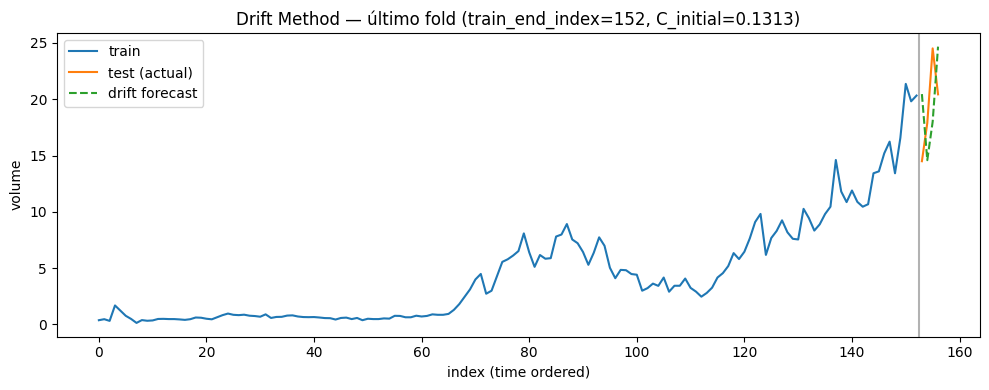

In [814]:
# Plot do último fold (visualização treino/teste/pred)
last = cv_splits[-1]
train = series.iloc[last[0]].reset_index(drop=True)
test = series.iloc[last[1]].reset_index(drop=True)
h = len(test)

# Recria one-step-ahead rolling forecast
preds = []
for j in range(h):
    if j == 0:
        history = train
    else:
        history = pd.concat([train, test.iloc[:j]], ignore_index=True)
    
    y_T = history.iloc[-1]
    y_1 = history.iloc[0]
    T = len(history)
    C = (y_T - y_1) / (T - 1)
    pred = y_T + C
    preds.append(pred)
preds = np.array(preds)

# Calcula C inicial apenas para o título
C_initial = (train.iloc[-1] - train.iloc[0]) / (len(train) - 1)

plt.figure(figsize=(10,4))
plt.plot(np.arange(len(train)), train, label="train", color="C0")
plt.plot(np.arange(len(train), len(train)+h), test, label="test (actual)", color="C1")
plt.plot(np.arange(len(train), len(train)+h), preds, label="drift forecast", color="C2", linestyle="--")
plt.axvline(len(train)-0.5, color="k", alpha=0.3)
plt.legend()
plt.title(f"Drift Method — último fold (train_end_index={last[0].stop-1}, C_initial={C_initial:.4f})")
plt.xlabel("index (time ordered)")
plt.ylabel("volume")
plt.tight_layout()
plt.show()

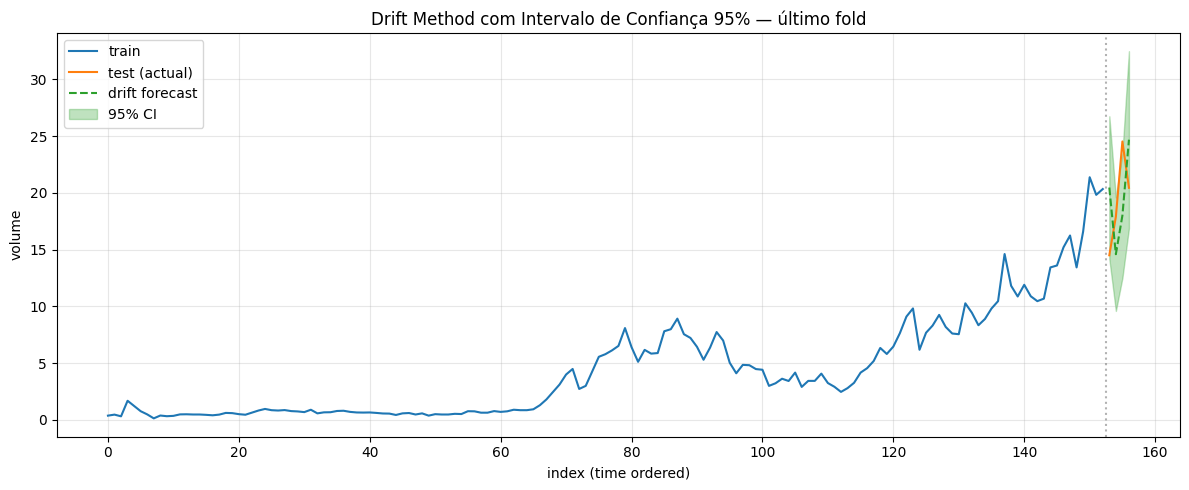

Intervalo de Confiança (95%) - one-step-ahead rolling forecast
  Primeira previsão: 20.46 [14.18, 26.74]
  Última previsão: 24.68 [16.88, 32.47]


In [815]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# último fold
last = cv_splits[-1]
train = series.iloc[last[0]].reset_index(drop=True)
test = series.iloc[last[1]].reset_index(drop=True)
h = len(test)

# Recria one-step-ahead rolling forecast com intervalos de confiança
preds = []
lower_bounds = []
upper_bounds = []

for j in range(h):
    if j == 0:
        history = train
    else:
        history = pd.concat([train, test.iloc[:j]], ignore_index=True)
    
    # previsão pontual (drift)
    y_T = history.iloc[-1]
    y_1 = history.iloc[0]
    T = len(history)
    C = (y_T - y_1) / (T - 1)
    pred = y_T + C
    preds.append(pred)
    
    # intervalo de confiança: baseado no desvio padrão dos resíduos do drift
    # Calculamos os resíduos do modelo drift no histórico
    drift_fitted = [y_1 + k * C for k in range(T)]
    residuals = history - drift_fitted
    std_residuals = np.std(residuals, ddof=1)
    
    # margem de erro (95% de confiança)
    z_score = stats.norm.ppf(0.975)  # 1.96 para 95%
    margin_of_error = z_score * std_residuals
    
    lower_bounds.append(pred - margin_of_error)
    upper_bounds.append(pred + margin_of_error)

preds = np.array(preds)
lower = np.array(lower_bounds)
upper = np.array(upper_bounds)

# plot
fig, ax = plt.subplots(figsize=(12, 5))

# treino
train_idx = np.arange(len(train))
ax.plot(train_idx, train, label="train", color="C0", linewidth=1.5)

# teste + previsão + intervalo
test_idx = np.arange(len(train), len(train) + h)
ax.plot(test_idx, test, label="test (actual)", color="C1", linewidth=1.5)
ax.plot(test_idx, preds, label="drift forecast", color="C2", linestyle="--", linewidth=1.5)
ax.fill_between(test_idx, lower, upper, alpha=0.3, color="C2", label="95% CI")

# separador treino/teste
ax.axvline(len(train) - 0.5, color="k", alpha=0.3, linestyle=":")

ax.legend()
ax.set_title(f"Drift Method com Intervalo de Confiança 95% — último fold")
ax.set_xlabel("index (time ordered)")
ax.set_ylabel("volume")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Intervalo de Confiança (95%) - one-step-ahead rolling forecast")
print(f"  Primeira previsão: {preds[0]:.2f} [{lower[0]:.2f}, {upper[0]:.2f}]")
print(f"  Última previsão: {preds[-1]:.2f} [{lower[-1]:.2f}, {upper[-1]:.2f}]")

In [816]:
import numpy as np

alpha = 0.05  # nível de significância (IC 95%)

# cobertura e taxa de violação
coverage = np.sum((test >= lower) & (test <= upper)) / len(test) * 100
violation_rate = 100 - coverage

# largura média do intervalo
avg_width = np.mean(upper - lower)
train_range = train.max() - train.min()
pinaw = avg_width / train_range * 100

# Winkler Score (penaliza largura + violações)
winkler_scores = []
for i, y_t in enumerate(test):
    width = upper[i] - lower[i]
    if y_t < lower[i]:
        ws = width + (2 / alpha) * (lower[i] - y_t)
    elif y_t > upper[i]:
        ws = width + (2 / alpha) * (y_t - upper[i])
    else:
        ws = width
    winkler_scores.append(ws)

mean_winkler = np.mean(winkler_scores)

print("=" * 60)
print("MÉTRICAS DO INTERVALO DE CONFIANÇA (95%) - DRIFT METHOD")
print("One-step-ahead rolling forecast")
print("=" * 60)
print(f"\n1. Cobertura (Coverage):")
print(f"   {coverage:.2f}% (ideal: ~95%)")

print(f"\n2. Taxa de Violação:")
print(f"   {violation_rate:.2f}% (ideal: ~5%)")

print(f"\n3. Largura média do intervalo:")
print(f"   {avg_width:.4f}")

print(f"\n4. PINAW (normalizado pelo range de treino):")
print(f"   {pinaw:.2f}% (menor = intervalo mais estreito)")

print(f"\n5. Winkler Score (média):")
print(f"   {mean_winkler:.4f}")
print(f"   (Menor é melhor: combina largura + penalidade por violações)")

MÉTRICAS DO INTERVALO DE CONFIANÇA (95%) - DRIFT METHOD
One-step-ahead rolling forecast

1. Cobertura (Coverage):
   75.00% (ideal: ~95%)

2. Taxa de Violação:
   25.00% (ideal: ~5%)

3. Largura média do intervalo:
   12.2785

4. PINAW (normalizado pelo range de treino):
   57.84% (menor = intervalo mais estreito)

5. Winkler Score (média):
   22.4909
   (Menor é melhor: combina largura + penalidade por violações)


### Método da Média Móvel (Rolling Mean)

O método da média móvel utiliza a média dos últimos $K$ valores observados como previsão para o futuro. Ele suaviza as flutuações de curto prazo e pode capturar tendências locais, mas não lida bem com sazonalidade forte ou tendências de longo prazo.

A previsão para $h$ períodos à frente é dada por:

$\hat{y}_{T+h|T} = \frac{y_{T} + y_{T-1} + ... + y_{T-K+1}}{K}$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $y_i$ são os valores observados.
- $K$ é o número de períodos usados para calcular a média móvel.

Este baseline é mais reativo a mudanças recentes na série do que o Método da Média simples. O parâmetro $K$ pode ser ajustado; um $K$ menor torna a previsão mais responsiva a mudanças recentes, enquanto um $K$ maior a torna mais suave.

In [817]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Janela da média móvel
K = 12  # ajuste conforme necessário (ex: 12 para ~3 meses de dados semanais)

rows = []
for i, (tr_slice, te_slice) in enumerate(cv_splits, start=1):
    train = series.iloc[tr_slice].reset_index(drop=True)
    test = series.iloc[te_slice].reset_index(drop=True)
    h = len(test)
    
    # One-step-ahead rolling forecast
    preds = []
    for j in range(h):
        # Para cada ponto, usa todos os dados reais até aquele momento
        if j == 0:
            history = train
        else:
            history = pd.concat([train, test.iloc[:j]], ignore_index=True)
        
        # Calcula a média móvel dos últimos K valores
        if len(history) >= K:
            rolling_mean = history.iloc[-K:].mean()
        else:
            rolling_mean = history.mean()
        
        preds.append(rolling_mean)
    
    preds = np.array(preds)
    mae = mean_absolute_error(test, preds)
    rmse = np.sqrt(mean_squared_error(test, preds))
    denom = np.where(np.abs(test.values) < 1e-9, 1e-9, test.values)
    mape = np.mean(np.abs((test.values - preds) / denom)) * 100
    rows.append({
        "fold": i,
        "train_end_index": tr_slice.stop - 1,
        "train_size": len(train),
        "horizon": h,
        "window_K": K,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

res_rolling_mean = pd.DataFrame(rows)
# res_rolling_mean.to_csv("baseline_rolling_mean_folds.csv", index=False)
res_rolling_mean

,fold,train_end_index,train_size,horizon,window_K,MAE,RMSE,MAPE
0,1,119,120,4,12,3.771042,3.885280,44.980949
1,2,120,121,4,12,3.298333,3.699612,37.758896
2,3,121,122,4,12,2.891250,3.407592,32.401010
3,4,122,123,4,12,2.249167,2.729060,25.856609
4,5,123,124,4,12,1.678958,1.822330,20.438802
5,6,124,125,4,12,1.791667,1.869322,21.274721
6,7,125,126,4,12,1.386042,1.656796,15.996514
7,8,126,127,4,12,0.933750,1.338569,10.598948
8,9,127,128,4,12,0.931667,1.334713,9.913408
9,10,128,129,4,12,1.000000,1.391445,10.235101


In [818]:
# agregados
agg = res_rolling_mean.agg({
    "MAE": ["mean","std"],
    "RMSE": ["mean","std"],
    "MAPE": ["mean","std"]
}).T
print("Resumo agregado (Rolling Mean Method):")
display(agg)

print("\nLinhas por fold:")
display(res_rolling_mean)

Resumo agregado (Rolling Mean Method):


,mean,std
MAE,2.480043,1.446879
RMSE,2.904220,1.556083
MAPE,18.886862,8.995653



Linhas por fold:


,fold,train_end_index,train_size,horizon,window_K,MAE,RMSE,MAPE
0,1,119,120,4,12,3.771042,3.885280,44.980949
1,2,120,121,4,12,3.298333,3.699612,37.758896
2,3,121,122,4,12,2.891250,3.407592,32.401010
3,4,122,123,4,12,2.249167,2.729060,25.856609
4,5,123,124,4,12,1.678958,1.822330,20.438802
5,6,124,125,4,12,1.791667,1.869322,21.274721
6,7,125,126,4,12,1.386042,1.656796,15.996514
7,8,126,127,4,12,0.933750,1.338569,10.598948
8,9,127,128,4,12,0.931667,1.334713,9.913408
9,10,128,129,4,12,1.000000,1.391445,10.235101


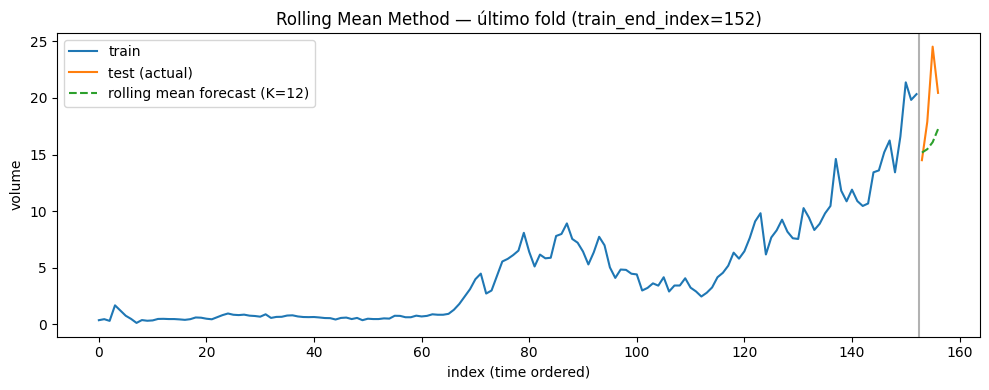

In [819]:
# Plot do último fold (visualização treino/teste/pred)
last = cv_splits[-1]
train = series.iloc[last[0]].reset_index(drop=True)
test = series.iloc[last[1]].reset_index(drop=True)
h = len(test)

# Recria one-step-ahead rolling forecast
preds = []
for j in range(h):
    if j == 0:
        history = train
    else:
        history = pd.concat([train, test.iloc[:j]], ignore_index=True)
    
    if len(history) >= K:
        rolling_mean = history.iloc[-K:].mean()
    else:
        rolling_mean = history.mean()
    preds.append(rolling_mean)
preds = np.array(preds)

plt.figure(figsize=(10,4))
plt.plot(np.arange(len(train)), train, label="train", color="C0")
plt.plot(np.arange(len(train), len(train)+h), test, label="test (actual)", color="C1")
plt.plot(np.arange(len(train), len(train)+h), preds, label=f"rolling mean forecast (K={K})", color="C2", linestyle="--")
plt.axvline(len(train)-0.5, color="k", alpha=0.3)
plt.legend()
plt.title(f"Rolling Mean Method — último fold (train_end_index={last[0].stop-1})")
plt.xlabel("index (time ordered)")
plt.ylabel("volume")
plt.tight_layout()
plt.show()

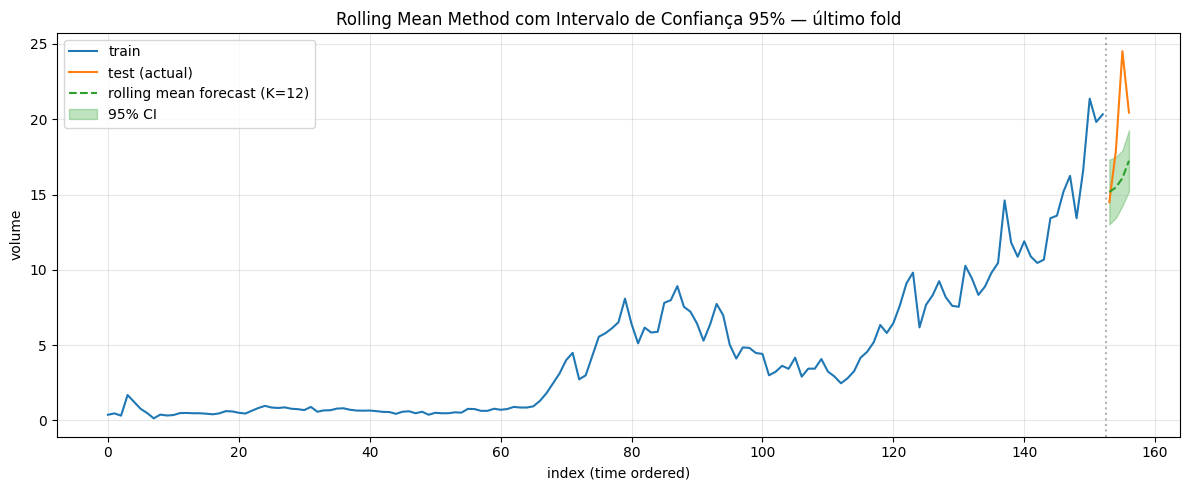

Intervalo de Confiança (95%) - one-step-ahead rolling forecast
  Primeira previsão: 15.17 [13.02, 17.32]
  Última previsão: 17.24 [15.21, 19.28]


In [820]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# último fold
last = cv_splits[-1]
train = series.iloc[last[0]].reset_index(drop=True)
test = series.iloc[last[1]].reset_index(drop=True)
h = len(test)

# Recria one-step-ahead rolling forecast com intervalos de confiança
preds = []
lower_bounds = []
upper_bounds = []

for j in range(h):
    if j == 0:
        history = train
    else:
        history = pd.concat([train, test.iloc[:j]], ignore_index=True)
    
    # previsão pontual (rolling mean)
    if len(history) >= K:
        rolling_mean = history.iloc[-K:].mean()
        window = history.iloc[-K:]
    else:
        rolling_mean = history.mean()
        window = history
    preds.append(rolling_mean)
    
    # intervalo de confiança: baseado no desvio padrão da janela
    std_window = np.std(window, ddof=1)
    
    # margem de erro (95% de confiança)
    z_score = stats.norm.ppf(0.975)  # 1.96 para 95%
    margin_of_error = z_score * std_window / np.sqrt(len(window))
    
    lower_bounds.append(rolling_mean - margin_of_error)
    upper_bounds.append(rolling_mean + margin_of_error)

preds = np.array(preds)
lower = np.array(lower_bounds)
upper = np.array(upper_bounds)

# plot
fig, ax = plt.subplots(figsize=(12, 5))

# treino
train_idx = np.arange(len(train))
ax.plot(train_idx, train, label="train", color="C0", linewidth=1.5)

# teste + previsão + intervalo
test_idx = np.arange(len(train), len(train) + h)
ax.plot(test_idx, test, label="test (actual)", color="C1", linewidth=1.5)
ax.plot(test_idx, preds, label=f"rolling mean forecast (K={K})", color="C2", linestyle="--", linewidth=1.5)
ax.fill_between(test_idx, lower, upper, alpha=0.3, color="C2", label="95% CI")

# separador treino/teste
ax.axvline(len(train) - 0.5, color="k", alpha=0.3, linestyle=":")

ax.legend()
ax.set_title(f"Rolling Mean Method com Intervalo de Confiança 95% — último fold")
ax.set_xlabel("index (time ordered)")
ax.set_ylabel("volume")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Intervalo de Confiança (95%) - one-step-ahead rolling forecast")
print(f"  Primeira previsão: {preds[0]:.2f} [{lower[0]:.2f}, {upper[0]:.2f}]")
print(f"  Última previsão: {preds[-1]:.2f} [{lower[-1]:.2f}, {upper[-1]:.2f}]")

In [821]:
import numpy as np

alpha = 0.05  # nível de significância (IC 95%)

# cobertura e taxa de violação
coverage = np.sum((test >= lower) & (test <= upper)) / len(test) * 100
violation_rate = 100 - coverage

# largura média do intervalo
avg_width = np.mean(upper - lower)
train_range = train.max() - train.min()
pinaw = avg_width / train_range * 100

# Winkler Score (penaliza largura + violações)
winkler_scores = []
for i, y_t in enumerate(test):
    width = upper[i] - lower[i]
    if y_t < lower[i]:
        ws = width + (2 / alpha) * (lower[i] - y_t)
    elif y_t > upper[i]:
        ws = width + (2 / alpha) * (y_t - upper[i])
    else:
        ws = width
    winkler_scores.append(ws)

mean_winkler = np.mean(winkler_scores)

print("=" * 60)
print("MÉTRICAS DO INTERVALO DE CONFIANÇA (95%) - ROLLING MEAN")
print("One-step-ahead rolling forecast")
print("=" * 60)
print(f"\n1. Cobertura (Coverage):")
print(f"   {coverage:.2f}% (ideal: ~95%)")

print(f"\n2. Taxa de Violação:")
print(f"   {violation_rate:.2f}% (ideal: ~5%)")

print(f"\n3. Largura média do intervalo:")
print(f"   {avg_width:.4f}")

print(f"\n4. PINAW (normalizado pelo range de treino):")
print(f"   {pinaw:.2f}% (menor = intervalo mais estreito)")

print(f"\n5. Winkler Score (média):")
print(f"   {mean_winkler:.4f}")
print(f"   (Menor é melhor: combina largura + penalidade por violações)")

MÉTRICAS DO INTERVALO DE CONFIANÇA (95%) - ROLLING MEAN
One-step-ahead rolling forecast

1. Cobertura (Coverage):
   25.00% (ideal: ~95%)

2. Taxa de Violação:
   75.00% (ideal: ~5%)

3. Largura média do intervalo:
   4.0214

4. PINAW (normalizado pelo range de treino):
   18.94% (menor = intervalo mais estreito)

5. Winkler Score (média):
   85.5659
   (Menor é melhor: combina largura + penalidade por violações)


## Comparação de Todos os Baselines

In [841]:
# Tabela comparativa de todos os baselines
import pandas as pd

# Resumo de cada método
summary_data = {
    "Método": ["Mean", "Naive", "Seasonal Naive", "Drift", "Rolling Mean"],
    "MAE": [
        res_mean["MAE"].mean(),
        res_naive["MAE"].mean(),
        res_seasonal_naive["MAE"].mean(),
        res_drift["MAE"].mean(),
        res_rolling_mean["MAE"].mean()
    ],
    "MAE_std": [
        res_mean["MAE"].std(),
        res_naive["MAE"].std(),
        res_seasonal_naive["MAE"].std(),
        res_drift["MAE"].std(),
        res_rolling_mean["MAE"].std()
    ],
    "RMSE": [
        res_mean["RMSE"].mean(),
        res_naive["RMSE"].mean(),
        res_seasonal_naive["RMSE"].mean(),
        res_drift["RMSE"].mean(),
        res_rolling_mean["RMSE"].mean()
    ],
    "RMSE_std": [
        res_mean["RMSE"].std(),
        res_naive["RMSE"].std(),
        res_seasonal_naive["RMSE"].std(),
        res_drift["RMSE"].std(),
        res_rolling_mean["RMSE"].std()
    ],
    "MAPE": [
        res_mean["MAPE"].mean(),
        res_naive["MAPE"].mean(),
        res_seasonal_naive["MAPE"].mean(),
        res_drift["MAPE"].mean(),
        res_rolling_mean["MAPE"].mean()
    ],
    "MAPE_std": [
        res_mean["MAPE"].std(),
        res_naive["MAPE"].std(),
        res_seasonal_naive["MAPE"].std(),
        res_drift["MAPE"].std(),
        res_rolling_mean["MAPE"].std()
    ]
}

comparison_df = pd.DataFrame(summary_data)

# Identifica o melhor modelo para cada métrica (menor é melhor)
comparison_df["Best_MAE"] = comparison_df["MAE"] == comparison_df["MAE"].min()
comparison_df["Best_RMSE"] = comparison_df["RMSE"] == comparison_df["RMSE"].min()
comparison_df["Best_MAPE"] = comparison_df["MAPE"] == comparison_df["MAPE"].min()

print("=" * 80)
print("COMPARAÇÃO DE BASELINES - MÉTRICAS DE ERRO")
print("=" * 80)
display(comparison_df)

# Salva tabela
# comparison_df.to_csv("baseline_comparison.csv", index=False)

# Identifica o melhor modelo overall
print("\n" + "=" * 80)
print("MELHOR MODELO POR MÉTRICA:")
print("=" * 80)
for metric in ["MAE", "RMSE", "MAPE"]:
    best_idx = comparison_df[metric].idxmin()
    best_model = comparison_df.loc[best_idx, "Método"]
    best_value = comparison_df.loc[best_idx, metric]
    best_std = comparison_df.loc[best_idx, f"{metric}_std"]
    print(f"{metric:10s}: {best_model:20s} ({best_value:.4f} ± {best_std:.4f})")

# Exportar tabela para LaTeX
latex_table = comparison_df[["Método", "MAE", "RMSE", "MAPE"]].to_latex(
    index=False,
    float_format="%.4f",
    column_format='|l|c|c|c|',
    caption='Resultados médios dos modelos baseline na validação cruzada (8 folds).',
    label='tab:baseline_results',
    escape=False
)

# Salvar em arquivo
with open('baseline_table.tex', 'w', encoding='utf-8') as f:
    f.write(latex_table)

print("Tabela LaTeX salva em 'baseline_table.tex'")


COMPARAÇÃO DE BASELINES - MÉTRICAS DE ERRO


,Método,MAE,MAE_std,RMSE,RMSE_std,MAPE,MAPE_std,Best_MAE,Best_RMSE,Best_MAPE
0,Mean,8.655486,3.387206,8.793149,3.454942,69.886653,4.356549,False,False,False
1,Naive,1.747206,1.009968,2.053144,1.105658,14.308747,5.787623,False,False,False
2,Seasonal Naive,6.507206,4.512712,6.658787,4.558648,49.048764,18.448099,False,False,False
3,Drift,1.734616,1.008876,2.047200,1.106911,14.255857,5.781696,True,True,True
4,Rolling Mean,2.480043,1.446879,2.904220,1.556083,18.886862,8.995653,False,False,False



MELHOR MODELO POR MÉTRICA:
MAE       : Drift                (1.7346 ± 1.0089)
RMSE      : Drift                (2.0472 ± 1.1069)
MAPE      : Drift                (14.2559 ± 5.7817)
Tabela LaTeX salva em 'baseline_table.tex'


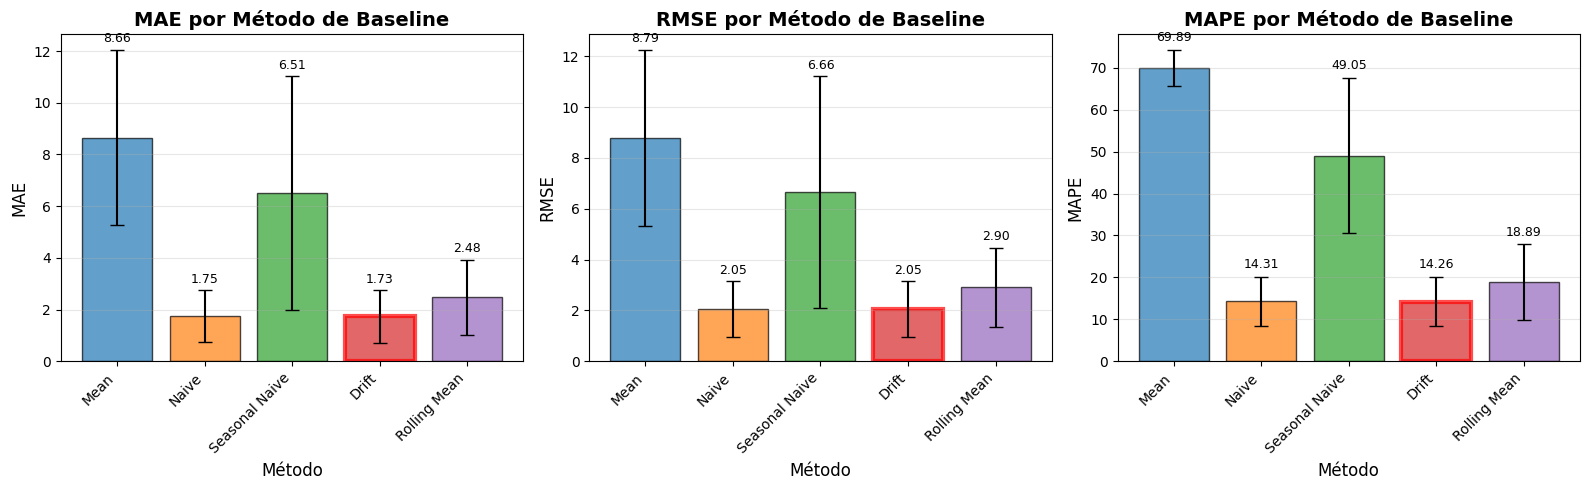

In [823]:
# Plot comparativo - barras com erro
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics = ["MAE", "RMSE", "MAPE"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    x = np.arange(len(comparison_df))
    values = comparison_df[metric].values
    errors = comparison_df[f"{metric}_std"].values
    
    bars = ax.bar(x, values, yerr=errors, capsize=5, color=colors, alpha=0.7, edgecolor='black')
    
    # Destaca o melhor modelo
    best_idx = comparison_df[metric].idxmin()
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(3)
    
    ax.set_xlabel("Método", fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f"{metric} por Método de Baseline", fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df["Método"], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    # Adiciona valores no topo das barras
    for i, (val, err) in enumerate(zip(values, errors)):
        ax.text(i, val + err + (max(values) * 0.02), f'{val:.2f}', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

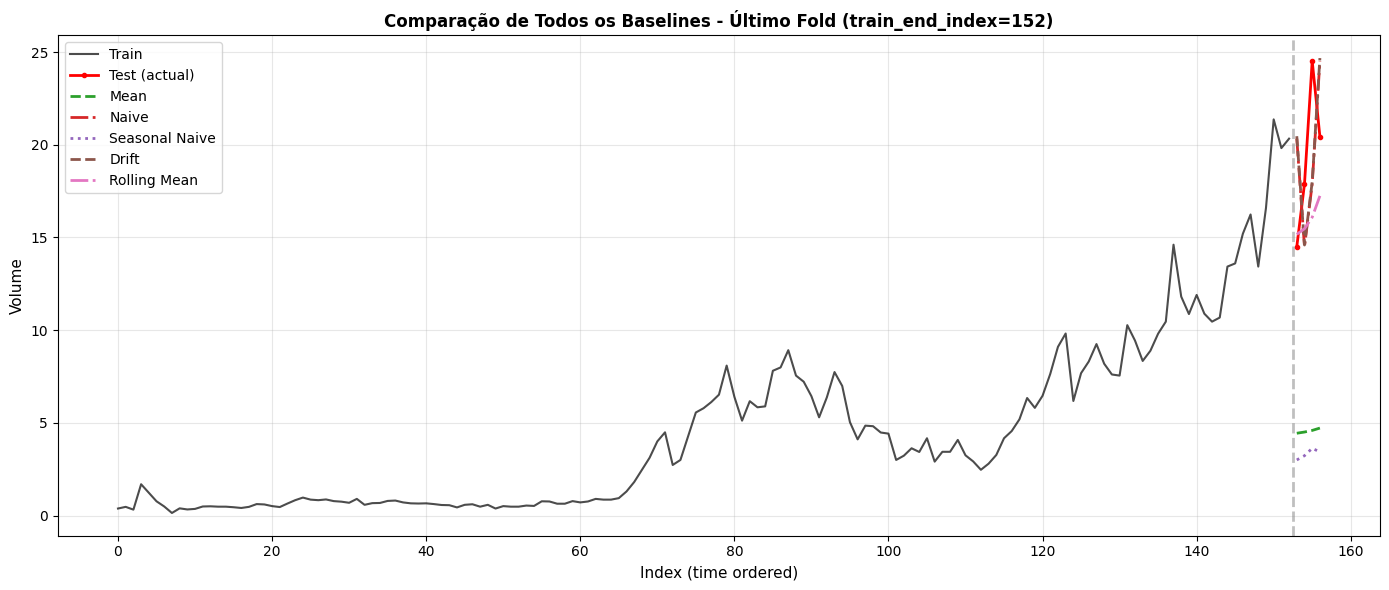

In [824]:
# Plot de Todos os Baselines no Mesmo Gráfico
import matplotlib.pyplot as plt
import numpy as np

# Usar o último fold como nos plots individuais
last = cv_splits[-1]
train = series.iloc[last[0]].reset_index(drop=True)
test = series.iloc[last[1]].reset_index(drop=True)
h = len(test)

# Dicionário para armazenar todas as previsões
all_predictions = {}

# 1. Mean Method
preds_mean = []
for j in range(h):
    if j == 0:
        history = train
    else:
        history = pd.concat([train, test.iloc[:j]], ignore_index=True)
    preds_mean.append(history.mean())
all_predictions['Mean'] = np.array(preds_mean)

# 2. Naive Method
preds_naive = []
for j in range(h):
    if j == 0:
        last_value = train.iloc[-1]
    else:
        last_value = test.iloc[j-1]
    preds_naive.append(last_value)
all_predictions['Naive'] = np.array(preds_naive)

# 3. Seasonal Naive Method
m = 52
preds_seasonal = []
for j in range(h):
    if j == 0:
        history = train
    else:
        history = pd.concat([train, test.iloc[:j]], ignore_index=True)
    if len(history) >= m:
        preds_seasonal.append(history.iloc[-m])
    else:
        preds_seasonal.append(history.iloc[-1])
all_predictions['Seasonal Naive'] = np.array(preds_seasonal)

# 4. Drift Method
preds_drift = []
for j in range(h):
    if j == 0:
        history = train
    else:
        history = pd.concat([train, test.iloc[:j]], ignore_index=True)
    y_T = history.iloc[-1]
    y_1 = history.iloc[0]
    C = (y_T - y_1) / (len(history) - 1)
    preds_drift.append(y_T + C)
all_predictions['Drift'] = np.array(preds_drift)

# 5. Rolling Mean Method
K = 12
preds_rolling = []
for j in range(h):
    if j == 0:
        history = train
    else:
        history = pd.concat([train, test.iloc[:j]], ignore_index=True)
    if len(history) >= K:
        preds_rolling.append(history.iloc[-K:].mean())
    else:
        preds_rolling.append(history.mean())
all_predictions['Rolling Mean'] = np.array(preds_rolling)

# Criar o plot único com todos os baselines
plt.figure(figsize=(14, 6))

# Plot treino
plt.plot(np.arange(len(train)), train, label="Train", color="black", linewidth=1.5, alpha=0.7)

# Plot teste (valores reais)
plt.plot(np.arange(len(train), len(train)+h), test, 
         label="Test (actual)", color="red", linewidth=2, marker='o', markersize=3)

# Plot de cada baseline
colors = ['C2', 'C3', 'C4', 'C5', 'C6']
linestyles = ['--', '-.', ':', '--', '-.']

for (model_name, preds), color, ls in zip(all_predictions.items(), colors, linestyles):
    plt.plot(np.arange(len(train), len(train)+h), preds, 
             label=f"{model_name}", color=color, linestyle=ls, linewidth=2)

# Linha vertical separando treino e teste
plt.axvline(len(train)-0.5, color="gray", alpha=0.5, linewidth=2, linestyle='--')

plt.legend(loc='best', fontsize=10)
plt.title(f"Comparação de Todos os Baselines - Último Fold (train_end_index={last[0].stop-1})", 
          fontsize=12, fontweight='bold')
plt.xlabel("Index (time ordered)", fontsize=11)
plt.ylabel("Volume", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Análise de Resíduos do Melhor Modelo

Baseado nas métricas MAE, RMSE e MAPE, o **Drift Method** apresentou os melhores resultados. Vamos realizar uma análise detalhada dos resíduos deste modelo para verificar se as suposições estatísticas são satisfeitas.

In [825]:
# Calcula resíduos do Drift Method para todos os folds
import numpy as np
import pandas as pd

all_residuals = []
all_predictions = []
all_actuals = []

for i, (tr_slice, te_slice) in enumerate(cv_splits, start=1):
    train = series.iloc[tr_slice].reset_index(drop=True)
    test = series.iloc[te_slice].reset_index(drop=True)
    h = len(test)
    
    # One-step-ahead rolling forecast (Drift)
    preds = []
    for j in range(h):
        if j == 0:
            history = train
        else:
            history = pd.concat([train, test.iloc[:j]], ignore_index=True)
        
        y_T = history.iloc[-1]
        y_1 = history.iloc[0]
        T = len(history)
        C = (y_T - y_1) / (T - 1)
        pred = y_T + C
        preds.append(pred)
    
    preds = np.array(preds)
    residuals = test.values - preds
    
    all_residuals.extend(residuals)
    all_predictions.extend(preds)
    all_actuals.extend(test.values)

all_residuals = np.array(all_residuals)
all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)

print("=" * 60)
print("ESTATÍSTICAS DOS RESÍDUOS - DRIFT METHOD")
print("=" * 60)
print(f"Número total de previsões: {len(all_residuals)}")
print(f"Média dos resíduos: {np.mean(all_residuals):.6f}")
print(f"Desvio padrão dos resíduos: {np.std(all_residuals):.6f}")
print(f"Mínimo: {np.min(all_residuals):.4f}")
print(f"Máximo: {np.max(all_residuals):.4f}")
print(f"Mediana: {np.median(all_residuals):.4f}")

ESTATÍSTICAS DOS RESÍDUOS - DRIFT METHOD
Número total de previsões: 136
Média dos resíduos: 0.274068
Desvio padrão dos resíduos: 2.303287
Mínimo: -5.9612
Máximo: 6.5163
Mediana: 0.4902


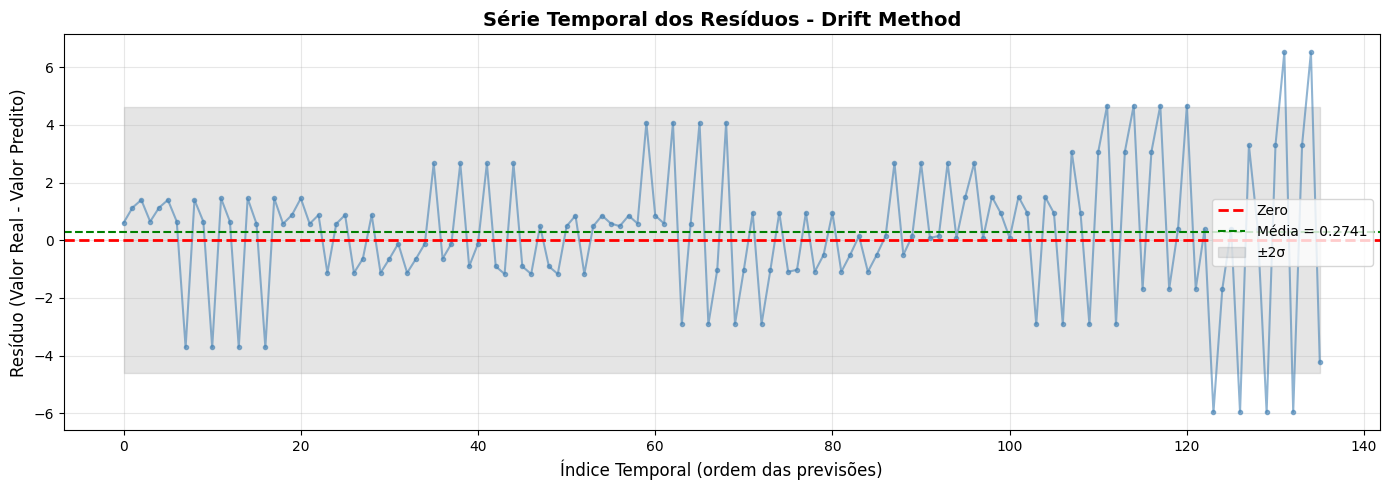

Estatísticas básicas:
  Média: 0.274068
  Desvio Padrão: 2.303287
  Mínimo: -5.9612
  Máximo: 6.5163


In [826]:
# === PARTE 1: SÉRIE TEMPORAL DOS RESÍDUOS ===
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(all_residuals, marker='o', linestyle='-', markersize=3, alpha=0.6, color='steelblue')
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero')
ax.axhline(y=np.mean(all_residuals), color='green', linestyle='--', linewidth=1.5, 
           label=f'Média = {np.mean(all_residuals):.4f}')
ax.fill_between(range(len(all_residuals)), 
                 -2*np.std(all_residuals), 
                 2*np.std(all_residuals), 
                 alpha=0.2, color='gray', label='±2σ')

ax.set_xlabel('Índice Temporal (ordem das previsões)', fontsize=12)
ax.set_ylabel('Resíduo (Valor Real - Valor Predito)', fontsize=12)
ax.set_title('Série Temporal dos Resíduos - Drift Method', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Estatísticas básicas:")
print(f"  Média: {np.mean(all_residuals):.6f}")
print(f"  Desvio Padrão: {np.std(all_residuals):.6f}")
print(f"  Mínimo: {np.min(all_residuals):.4f}")
print(f"  Máximo: {np.max(all_residuals):.4f}")

### Interpretação - Série Temporal dos Resíduos

**O que esperamos ver:**
- Resíduos flutuando aleatoriamente em torno de zero (linha vermelha tracejada)
- Ausência de padrões sistemáticos ou tendências
- Maioria dos pontos dentro da banda ±2σ (área sombreada)

**Análise:**
- **Média dos resíduos**: A linha verde indica a média dos resíduos. Idealmente, deve estar muito próxima de zero, indicando que o modelo não possui viés sistemático.
- **Dispersão**: A banda ±2σ mostra onde esperamos encontrar ~95% dos resíduos se seguirem distribuição normal.
- **Padrões temporais**: Se observarmos ciclos, tendências ou mudanças na variância ao longo do tempo, isso indica que o modelo não capturou toda a estrutura da série.
- **Outliers**: Pontos muito distantes da banda podem indicar observações atípicas ou períodos onde o modelo teve dificuldade em prever.

### Parte 2: Análise de Densidade e Normalidade

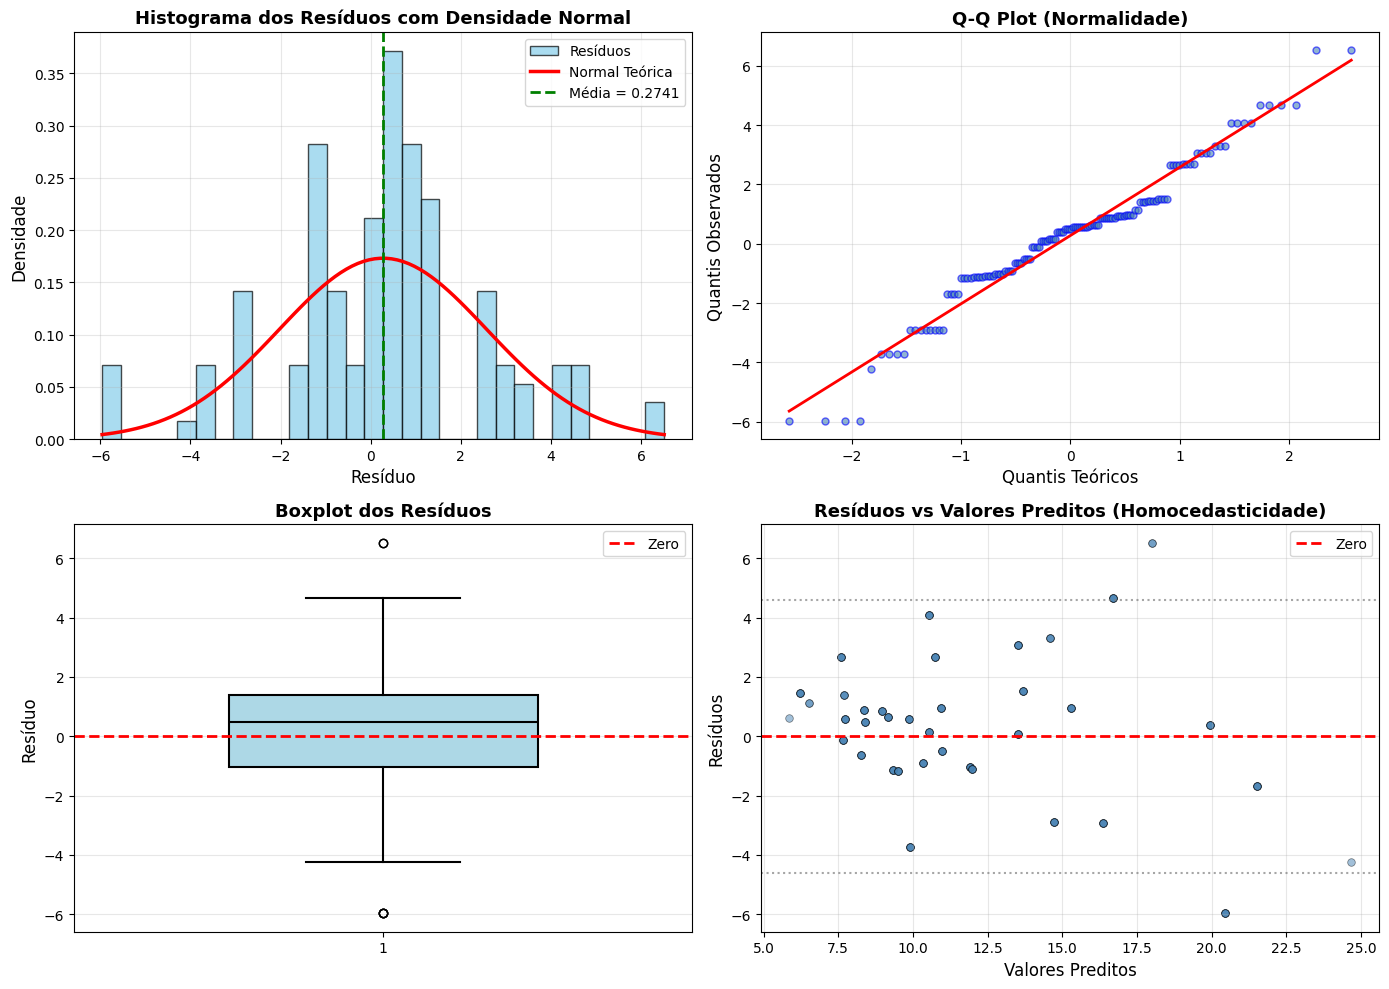

In [827]:
# === PARTE 2: ANÁLISE DE DENSIDADE E NORMALIDADE ===
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histograma com curva normal
ax1 = axes[0, 0]
ax1.hist(all_residuals, bins=30, density=True, alpha=0.7, edgecolor='black', color='skyblue', label='Resíduos')
mu, sigma = np.mean(all_residuals), np.std(all_residuals)
x = np.linspace(all_residuals.min(), all_residuals.max(), 100)
ax1.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2.5, label='Normal Teórica')
ax1.axvline(mu, color='green', linestyle='--', linewidth=2, label=f'Média = {mu:.4f}')
ax1.set_xlabel('Resíduo', fontsize=12)
ax1.set_ylabel('Densidade', fontsize=12)
ax1.set_title('Histograma dos Resíduos com Densidade Normal', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Q-Q Plot
ax2 = axes[0, 1]
stats.probplot(all_residuals, dist="norm", plot=ax2)
ax2.get_lines()[0].set_markerfacecolor('steelblue')
ax2.get_lines()[0].set_markersize(5)
ax2.get_lines()[0].set_alpha(0.6)
ax2.get_lines()[1].set_color('red')
ax2.get_lines()[1].set_linewidth(2)
ax2.set_title('Q-Q Plot (Normalidade)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Quantis Teóricos', fontsize=12)
ax2.set_ylabel('Quantis Observados', fontsize=12)
ax2.grid(alpha=0.3)

# 3. Boxplot
ax3 = axes[1, 0]
bp = ax3.boxplot(all_residuals, vert=True, patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_edgecolor('black')
bp['boxes'][0].set_linewidth(1.5)
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='black', linewidth=1.5)
ax3.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax3.set_ylabel('Resíduo', fontsize=12)
ax3.set_title('Boxplot dos Resíduos', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3, axis='y')

# 4. Resíduos vs Valores Preditos (Homocedasticidade)
ax4 = axes[1, 1]
ax4.scatter(all_predictions, all_residuals, alpha=0.5, s=30, color='steelblue', edgecolors='black', linewidth=0.5)
ax4.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero')
ax4.axhline(y=2*np.std(all_residuals), color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax4.axhline(y=-2*np.std(all_residuals), color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax4.set_xlabel('Valores Preditos', fontsize=12)
ax4.set_ylabel('Resíduos', fontsize=12)
ax4.set_title('Resíduos vs Valores Preditos (Homocedasticidade)', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [828]:
# Testes estatísticos de normalidade
from scipy.stats import shapiro, jarque_bera

print("=" * 70)
print("TESTES DE NORMALIDADE")
print("=" * 70)

# Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(all_residuals)
print(f"\n1. Teste de Shapiro-Wilk:")
print(f"   H₀: Os resíduos seguem distribuição normal")
print(f"   Estatística: {shapiro_stat:.6f}")
print(f"   p-valor: {shapiro_p:.6f}")
print(f"   Resultado: {'Não rejeitamos H₀ (resíduos são normais)' if shapiro_p > 0.05 else 'Rejeitamos H₀ (resíduos NÃO são normais)'} (α=0.05)")

# Jarque-Bera
jb_stat, jb_p = jarque_bera(all_residuals)
print(f"\n2. Teste de Jarque-Bera:")
print(f"   H₀: Os resíduos seguem distribuição normal")
print(f"   Estatística: {jb_stat:.6f}")
print(f"   p-valor: {jb_p:.6f}")
print(f"   Resultado: {'Não rejeitamos H₀ (resíduos são normais)' if jb_p > 0.05 else 'Rejeitamos H₀ (resíduos NÃO são normais)'} (α=0.05)")

# Teste t para média zero
from scipy.stats import ttest_1samp
t_stat, t_p = ttest_1samp(all_residuals, 0)
print(f"\n3. Teste t para Média Zero:")
print(f"   H₀: A média dos resíduos é zero")
print(f"   Estatística t: {t_stat:.6f}")
print(f"   p-valor: {t_p:.6f}")
print(f"   Resultado: {'Não rejeitamos H₀ (média é zero)' if t_p > 0.05 else 'Rejeitamos H₀ (média NÃO é zero)'} (α=0.05)")

print("=" * 70)

TESTES DE NORMALIDADE

1. Teste de Shapiro-Wilk:
   H₀: Os resíduos seguem distribuição normal
   Estatística: 0.967342
   p-valor: 0.002386
   Resultado: Rejeitamos H₀ (resíduos NÃO são normais) (α=0.05)

2. Teste de Jarque-Bera:
   H₀: Os resíduos seguem distribuição normal
   Estatística: 4.485482
   p-valor: 0.106167
   Resultado: Não rejeitamos H₀ (resíduos são normais) (α=0.05)

3. Teste t para Média Zero:
   H₀: A média dos resíduos é zero
   Estatística t: 1.382539
   p-valor: 0.169089
   Resultado: Não rejeitamos H₀ (média é zero) (α=0.05)


### Interpretação - Densidade e Normalidade

#### **Histograma com Densidade Normal:**
- A curva vermelha representa a distribuição normal teórica com mesma média e desvio padrão dos resíduos
- **Se os resíduos são normais**: O histograma deve se aproximar da curva vermelha
- **Desvios da normalidade**: Assimetria (skewness), excesso de valores extremos (kurtosis), múltiplos picos

#### **Q-Q Plot:**
- Compara os quantis dos resíduos observados com os quantis de uma distribuição normal teórica
- **Se os resíduos são normais**: Os pontos devem seguir aproximadamente a linha vermelha diagonal
- **Desvios**: 
  - Pontos curvando para cima nas extremidades → caudas pesadas (mais outliers que o esperado)
  - Pontos curvando para baixo nas extremidades → caudas leves
  - Padrão em "S" → assimetria

#### **Boxplot:**
- Mostra a distribuição dos resíduos e identifica outliers
- **Linha central**: Mediana (deve estar próxima de zero)
- **Caixa**: Intervalo interquartil (IQR) - 50% dos dados
- **Bigodes**: Valores dentro de 1.5×IQR
- **Pontos isolados**: Outliers

#### **Resíduos vs Valores Preditos (Homocedasticidade):**
- Verifica se a variância dos resíduos é constante
- **Homocedasticidade (desejável)**: Pontos distribuídos aleatoriamente em torno de zero, sem padrões, com dispersão constante
- **Heterocedasticidade (problemática)**: 
  - Padrão de "funil" → variância aumenta/diminui com valores preditos
  - Padrões curvos → relação não-linear não capturada
  - Agrupamentos → diferentes regimes de variância

### Parte 3: Análise de Autocorrelação

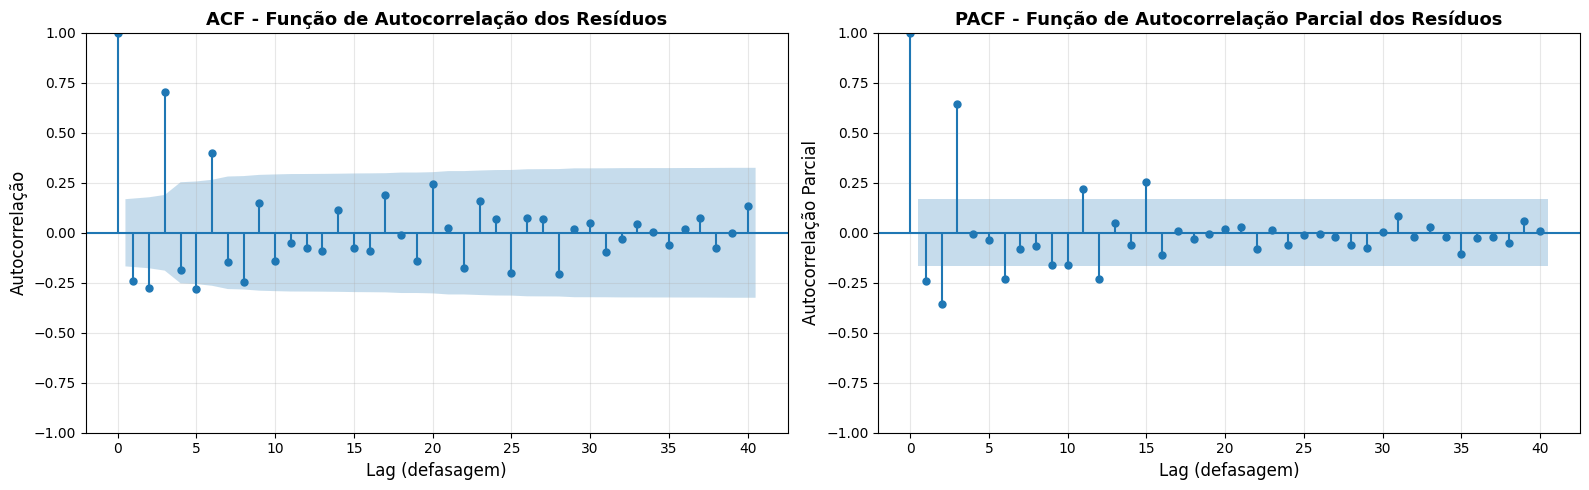

In [829]:
# === PARTE 3: ANÁLISE DE AUTOCORRELAÇÃO ===
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF - Função de Autocorrelação
ax1 = axes[0]
plot_acf(all_residuals, lags=40, ax=ax1, alpha=0.05)
ax1.set_title('ACF - Função de Autocorrelação dos Resíduos', fontsize=13, fontweight='bold')
ax1.set_xlabel('Lag (defasagem)', fontsize=12)
ax1.set_ylabel('Autocorrelação', fontsize=12)
ax1.grid(alpha=0.3)

# PACF - Função de Autocorrelação Parcial
ax2 = axes[1]
plot_pacf(all_residuals, lags=40, ax=ax2, alpha=0.05, method='ywm')
ax2.set_title('PACF - Função de Autocorrelação Parcial dos Resíduos', fontsize=13, fontweight='bold')
ax2.set_xlabel('Lag (defasagem)', fontsize=12)
ax2.set_ylabel('Autocorrelação Parcial', fontsize=12)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [830]:
# Teste de Ljung-Box para autocorrelação
from statsmodels.stats.diagnostic import acorr_ljungbox

print("=" * 70)
print("TESTE DE LJUNG-BOX - AUTOCORRELAÇÃO DOS RESÍDUOS")
print("=" * 70)

lb_test = acorr_ljungbox(all_residuals, lags=20, return_df=True)

print(f"\nH₀: Os resíduos não possuem autocorrelação (são ruído branco)")
print(f"\nLags com autocorrelação significativa (p-valor < 0.05):")

significant_lags = lb_test[lb_test['lb_pvalue'] < 0.05]

if len(significant_lags) > 0:
    print(f"\n   Lags significativos: {significant_lags.index.tolist()}")
    print(f"\n   Detalhes:")
    for lag in significant_lags.index[:5]:  # Mostra primeiros 5
        print(f"   - Lag {lag}: p-valor = {lb_test.loc[lag, 'lb_pvalue']:.6f}")
    if len(significant_lags) > 5:
        print(f"   ... e mais {len(significant_lags) - 5} lags")
    print(f"\n   ⚠ Conclusão: REJEITAMOS H₀")
    print(f"   Os resíduos POSSUEM autocorrelação significativa")
    print(f"   Isso indica que há estrutura temporal não capturada pelo modelo")
else:
    print(f"\n   Nenhum lag com autocorrelação significativa")
    print(f"\n   ✓ Conclusão: NÃO REJEITAMOS H₀")
    print(f"   Os resíduos NÃO possuem autocorrelação (comportam-se como ruído branco)")
    print(f"   Isso é DESEJÁVEL - indica que o modelo capturou toda a estrutura temporal")

print("=" * 70)

TESTE DE LJUNG-BOX - AUTOCORRELAÇÃO DOS RESÍDUOS

H₀: Os resíduos não possuem autocorrelação (são ruído branco)

Lags com autocorrelação significativa (p-valor < 0.05):

   Lags significativos: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

   Detalhes:
   - Lag 1: p-valor = 0.004515
   - Lag 2: p-valor = 0.000084
   - Lag 3: p-valor = 0.000000
   - Lag 4: p-valor = 0.000000
   - Lag 5: p-valor = 0.000000
   ... e mais 15 lags

   ⚠ Conclusão: REJEITAMOS H₀
   Os resíduos POSSUEM autocorrelação significativa
   Isso indica que há estrutura temporal não capturada pelo modelo


### Interpretação - Autocorrelação dos Resíduos

#### **ACF (Função de Autocorrelação):**
- Mede a correlação entre o resíduo em um tempo $t$ e o resíduo em tempo $t-k$ (lag $k$)
- **Área sombreada azul**: Intervalo de confiança de 95% sob a hipótese de ruído branco
- **Se os resíduos são independentes (ruído branco)**: 
  - ~95% das barras devem estar dentro da área sombreada
  - Apenas ~5% podem ultrapassar por acaso
- **Autocorrelação significativa**: 
  - Muitas barras fora da área → modelo não capturou toda a dependência temporal
  - Padrão decrescente lento → presença de tendência
  - Picos em lags múltiplos de $m$ → sazonalidade não capturada

#### **PACF (Função de Autocorrelação Parcial):**
- Mede a correlação entre $t$ e $t-k$ **removendo** o efeito dos lags intermediários
- Útil para identificar a **ordem** de modelos autoregressivos (AR)
- **Se resíduos são ruído branco**: Todas as barras (exceto lag 0) devem estar na área sombreada
- **Interpretação de picos significativos**:
  - Pico no lag $k$ → correlação direta entre $t$ e $t-k$
  - Sugere que um modelo AR($k$) poderia melhorar as previsões

#### **Teste de Ljung-Box:**
- Testa formalmente se existe autocorrelação nos resíduos até um determinado lag
- **H₀**: Os resíduos são ruído branco (sem autocorrelação)
- **p-valor > 0.05**: Não rejeitamos H₀ → resíduos são independentes ✓
- **p-valor < 0.05**: Rejeitamos H₀ → existe autocorrelação residual ⚠
  - Indica que o modelo pode ser melhorado
  - Há estrutura temporal que não foi capturada

#### **Implicações práticas:**
- **Resíduos sem autocorrelação (desejável)**: O modelo extraiu toda a informação preditiva disponível
- **Resíduos com autocorrelação (problemático)**: 
  - Intervalos de confiança podem estar subestimados
  - Existe informação preditiva não utilizada
  - Considerar modelos mais complexos (ARIMA, SARIMA, etc.)

In [831]:
# === RESUMO FINAL DA ANÁLISE DE RESÍDUOS ===
import numpy as np
from scipy.stats import shapiro, jarque_bera

# Recalcula estatísticas para o resumo
shapiro_stat, shapiro_p = shapiro(all_residuals)
jb_stat, jb_p = jarque_bera(all_residuals)
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(all_residuals, lags=20, return_df=True)
significant_lags = lb_test[lb_test['lb_pvalue'] < 0.05]

print("=" * 80)
print("RESUMO FINAL - VALIDAÇÃO DAS SUPOSIÇÕES DO MODELO")
print("=" * 80)

print(f"\n{'Suposição':<40} {'Status':<15} {'Detalhe'}")
print("-" * 80)

# 1. Média zero
media_ok = abs(np.mean(all_residuals)) < 0.1
print(f"{'1. Média dos resíduos = 0':<40} {('✓ OK' if media_ok else '✗ FALHA'):<15} Média = {np.mean(all_residuals):.6f}")

# 2. Normalidade
normalidade_ok = (shapiro_p > 0.05) and (jb_p > 0.05)
print(f"{'2. Normalidade (Shapiro-Wilk)':<40} {('✓ OK' if shapiro_p > 0.05 else '✗ FALHA'):<15} p = {shapiro_p:.4f}")
print(f"{'   Normalidade (Jarque-Bera)':<40} {('✓ OK' if jb_p > 0.05 else '✗ FALHA'):<15} p = {jb_p:.4f}")

# 3. Homocedasticidade (verificação visual)
print(f"{'3. Homocedasticidade':<40} {'? VISUAL':<15} Ver gráfico Res vs Pred")

# 4. Independência (ausência de autocorrelação)
independencia_ok = len(significant_lags) == 0
print(f"{'4. Independência (Ljung-Box)':<40} {('✓ OK' if independencia_ok else '✗ FALHA'):<15} {len(significant_lags)} lags significativos")

print("-" * 80)
print(f"\n{'VEREDICTO GERAL':<40} ", end='')
all_ok = media_ok and normalidade_ok and independencia_ok
if all_ok:
    print("✓ MODELO ADEQUADO")
    print("\nOs resíduos satisfazem as principais suposições estatísticas.")
    print("O modelo Drift capturou adequadamente a estrutura temporal dos dados.")
else:
    print("⚠ MODELO PODE SER MELHORADO")
    print("\nAlgumas suposições não foram satisfeitas completamente.")
    print("Considerar modelos mais complexos (ARIMA, SARIMA, etc.) pode melhorar as previsões.")

print("=" * 80)

RESUMO FINAL - VALIDAÇÃO DAS SUPOSIÇÕES DO MODELO

Suposição                                Status          Detalhe
--------------------------------------------------------------------------------
1. Média dos resíduos = 0                ✗ FALHA         Média = 0.274068
2. Normalidade (Shapiro-Wilk)            ✗ FALHA         p = 0.0024
   Normalidade (Jarque-Bera)             ✓ OK            p = 0.1062
3. Homocedasticidade                     ? VISUAL        Ver gráfico Res vs Pred
4. Independência (Ljung-Box)             ✗ FALHA         20 lags significativos
--------------------------------------------------------------------------------

VEREDICTO GERAL                          ⚠ MODELO PODE SER MELHORADO

Algumas suposições não foram satisfeitas completamente.
Considerar modelos mais complexos (ARIMA, SARIMA, etc.) pode melhorar as previsões.


# Modelos de Baseline COM Transformação BOX-COX

Nesta seção, vamos repetir toda a análise anterior, porém considerando que a **variância pode aumentar com o tempo** (heteroscedasticidade). Para estabilizar a variância, utilizaremos a **transformação de Box-Cox** antes de ajustar os modelos de baseline.

## Etapas:
1. **Verificação de Heteroscedasticidade**: Analisar se a variância aumenta ao longo do tempo
2. **Transformação de Box-Cox**: Encontrar o parâmetro λ ótimo e transformar os dados
3. **Ajuste dos Baselines**: Aplicar os mesmos 5 métodos nos dados transformados
4. **Avaliação e Comparação**: Comparar os resultados com e sem transformação

## 1. Verificação de Heteroscedasticidade

Antes de aplicar a transformação Box-Cox, vamos verificar se realmente existe heteroscedasticidade nos dados (variância não constante ao longo do tempo).

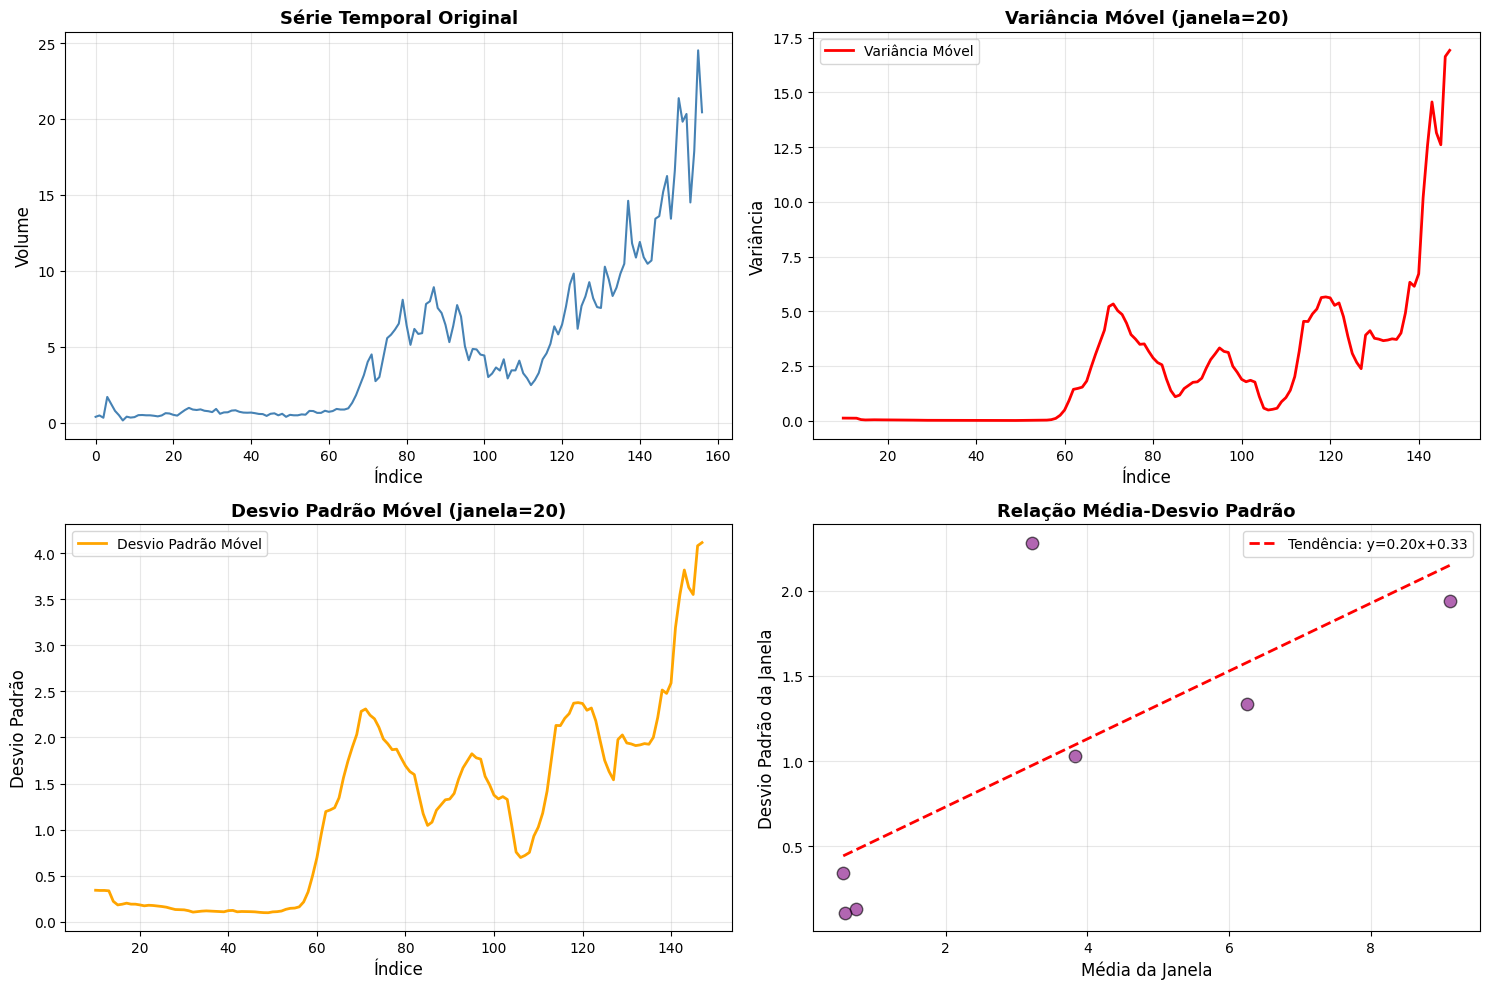


Correlação entre Média e Desvio Padrão: 0.7428
→ Forte evidência de HETEROSCEDASTICIDADE (variância aumenta com a média)


In [832]:
# Análise visual da heteroscedasticidade
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Vamos dividir a série em janelas e calcular a variância de cada janela
window_size = 20  # janela de 20 observações (~5 meses)
n_windows = len(series) // window_size

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Série temporal original
ax1 = axes[0, 0]
ax1.plot(series.index, series.values, linewidth=1.5, color='steelblue')
ax1.set_xlabel('Índice', fontsize=12)
ax1.set_ylabel('Volume', fontsize=12)
ax1.set_title('Série Temporal Original', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# 2. Variância móvel (rolling variance)
rolling_var = series.rolling(window=window_size, center=True).var()
ax2 = axes[0, 1]
ax2.plot(rolling_var.index, rolling_var.values, linewidth=2, color='red', label='Variância Móvel')
ax2.set_xlabel('Índice', fontsize=12)
ax2.set_ylabel('Variância', fontsize=12)
ax2.set_title(f'Variância Móvel (janela={window_size})', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Desvio padrão móvel
rolling_std = series.rolling(window=window_size, center=True).std()
ax3 = axes[1, 0]
ax3.plot(rolling_std.index, rolling_std.values, linewidth=2, color='orange', label='Desvio Padrão Móvel')
ax3.set_xlabel('Índice', fontsize=12)
ax3.set_ylabel('Desvio Padrão', fontsize=12)
ax3.set_title(f'Desvio Padrão Móvel (janela={window_size})', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Média vs Desvio Padrão por janela
windows_mean = []
windows_std = []
for i in range(n_windows):
    start_idx = i * window_size
    end_idx = start_idx + window_size
    window_data = series.iloc[start_idx:end_idx]
    windows_mean.append(window_data.mean())
    windows_std.append(window_data.std())

ax4 = axes[1, 1]
ax4.scatter(windows_mean, windows_std, s=80, alpha=0.6, color='purple', edgecolors='black')
# Linha de tendência
z = np.polyfit(windows_mean, windows_std, 1)
p = np.poly1d(z)
x_trend = np.linspace(min(windows_mean), max(windows_mean), 100)
ax4.plot(x_trend, p(x_trend), "r--", linewidth=2, label=f'Tendência: y={z[0]:.2f}x+{z[1]:.2f}')
ax4.set_xlabel('Média da Janela', fontsize=12)
ax4.set_ylabel('Desvio Padrão da Janela', fontsize=12)
ax4.set_title('Relação Média-Desvio Padrão', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlação entre média e desvio padrão
corr = np.corrcoef(windows_mean, windows_std)[0, 1]
print(f"\nCorrelação entre Média e Desvio Padrão: {corr:.4f}")
if corr > 0.5:
    print("→ Forte evidência de HETEROSCEDASTICIDADE (variância aumenta com a média)")
elif corr > 0.3:
    print("→ Moderada evidência de heteroscedasticidade")
else:
    print("→ Fraca evidência de heteroscedasticidade")

### Interpretação - Heteroscedasticidade

**O que estamos verificando:**
- **Variância Móvel**: Se aumenta ao longo do tempo, indica heteroscedasticidade
- **Relação Média-Desvio Padrão**: Se existe correlação positiva forte, a variância depende do nível da série

**Indicadores de Heteroscedasticidade:**
1. Variância móvel com tendência crescente ao longo do tempo
2. Desvio padrão móvel aumentando com o tempo
3. Correlação positiva entre média e desvio padrão nas janelas
4. Padrão de "funil" na série temporal (amplitude aumenta)

**Por que isso importa:**
- Heteroscedasticidade viola suposições de muitos modelos estatísticos
- Intervalos de confiança podem ser imprecisos
- Transformação Box-Cox pode estabilizar a variância

## 2. Transformação de Box-Cox

A transformação de Box-Cox é definida por:

$$
y(\lambda) = \begin{cases}
\frac{y^\lambda - 1}{\lambda} & \text{se } \lambda \neq 0 \\
\log(y) & \text{se } \lambda = 0
\end{cases}
$$

Onde $\lambda$ é o parâmetro de transformação encontrado por máxima verossimilhança. Valores comuns:
- $\lambda = 1$: Sem transformação
- $\lambda = 0.5$: Raiz quadrada
- $\lambda = 0$: Logaritmo natural
- $\lambda = -1$: Inverso

In [833]:
# Encontrar o lambda ótimo e aplicar transformação Box-Cox
from scipy.stats import boxcox
import numpy as np

# IMPORTANTE: Para evitar data leakage, calculamos lambda APENAS com dados de treino inicial
# Usamos os primeiros 120 pontos (initial_train) para estimar o parâmetro de transformação
train_initial = series.iloc[:120]  # Apenas treino inicial

# Box-Cox requer valores positivos
# Verificar se há valores <= 0
if (train_initial <= 0).any():
    print(f"AVISO: Série de treino contém {(train_initial <= 0).sum()} valores <= 0")
    print("Adicionando constante para tornar todos os valores positivos...")
    shift = abs(train_initial.min()) + 0.01
    train_positive = train_initial + shift
else:
    train_positive = train_initial.copy()
    shift = 0

# Aplicar Box-Cox APENAS NO TREINO para encontrar lambda
_, lambda_opt = boxcox(train_positive)

# Agora aplicar a transformação com lambda fixo em TODA a série
if shift > 0:
    series_positive = series + shift
else:
    series_positive = series.copy()

series_boxcox = boxcox(series_positive, lmbda=lambda_opt)
series_boxcox = pd.Series(series_boxcox, index=series.index)

print("=" * 70)
print("TRANSFORMAÇÃO BOX-COX (SEM DATA LEAKAGE)")
print("=" * 70)
print(f"Parâmetro λ (lambda) calculado com treino inicial (120 pontos): {lambda_opt:.6f}")
print(f"Interpretação:")
if abs(lambda_opt - 1) < 0.1:
    print("  → λ ≈ 1: Transformação quase linear (sem transformação)")
elif abs(lambda_opt - 0.5) < 0.1:
    print("  → λ ≈ 0.5: Transformação de raiz quadrada")
elif abs(lambda_opt) < 0.1:
    print("  → λ ≈ 0: Transformação logarítmica")
else:
    print(f"  → λ = {lambda_opt:.4f}")

if shift > 0:
    print(f"Nota: Valores foram deslocados +{shift:.4f} para garantir positividade")

# Mostrar estatísticas
print(f" Estatísticas da série original:")
print(f"  Média: {series.mean():.4f}")
print(f"  Desvio padrão: {series.std():.4f}")
print(f"  Min: {series.min():.4f}, Max: {series.max():.4f}")

print(f" Estatísticas da série transformada:")
print(f"  Média: {series_boxcox.mean():.4f}")
print(f"  Desvio padrão: {series_boxcox.std():.4f}")
print(f"  Min: {series_boxcox.min():.4f}, Max: {series_boxcox.max():.4f}")


TRANSFORMAÇÃO BOX-COX (SEM DATA LEAKAGE)
Parâmetro λ (lambda) calculado com treino inicial (120 pontos): -0.126994
Interpretação:
  → λ = -0.1270
 Estatísticas da série original:
  Média: 4.8204
  Desvio padrão: 5.1623
  Min: 0.1400, Max: 24.5200
 Estatísticas da série transformada:
  Média: 0.7375
  Desvio padrão: 1.1700
  Min: -2.2333, Max: 2.6293


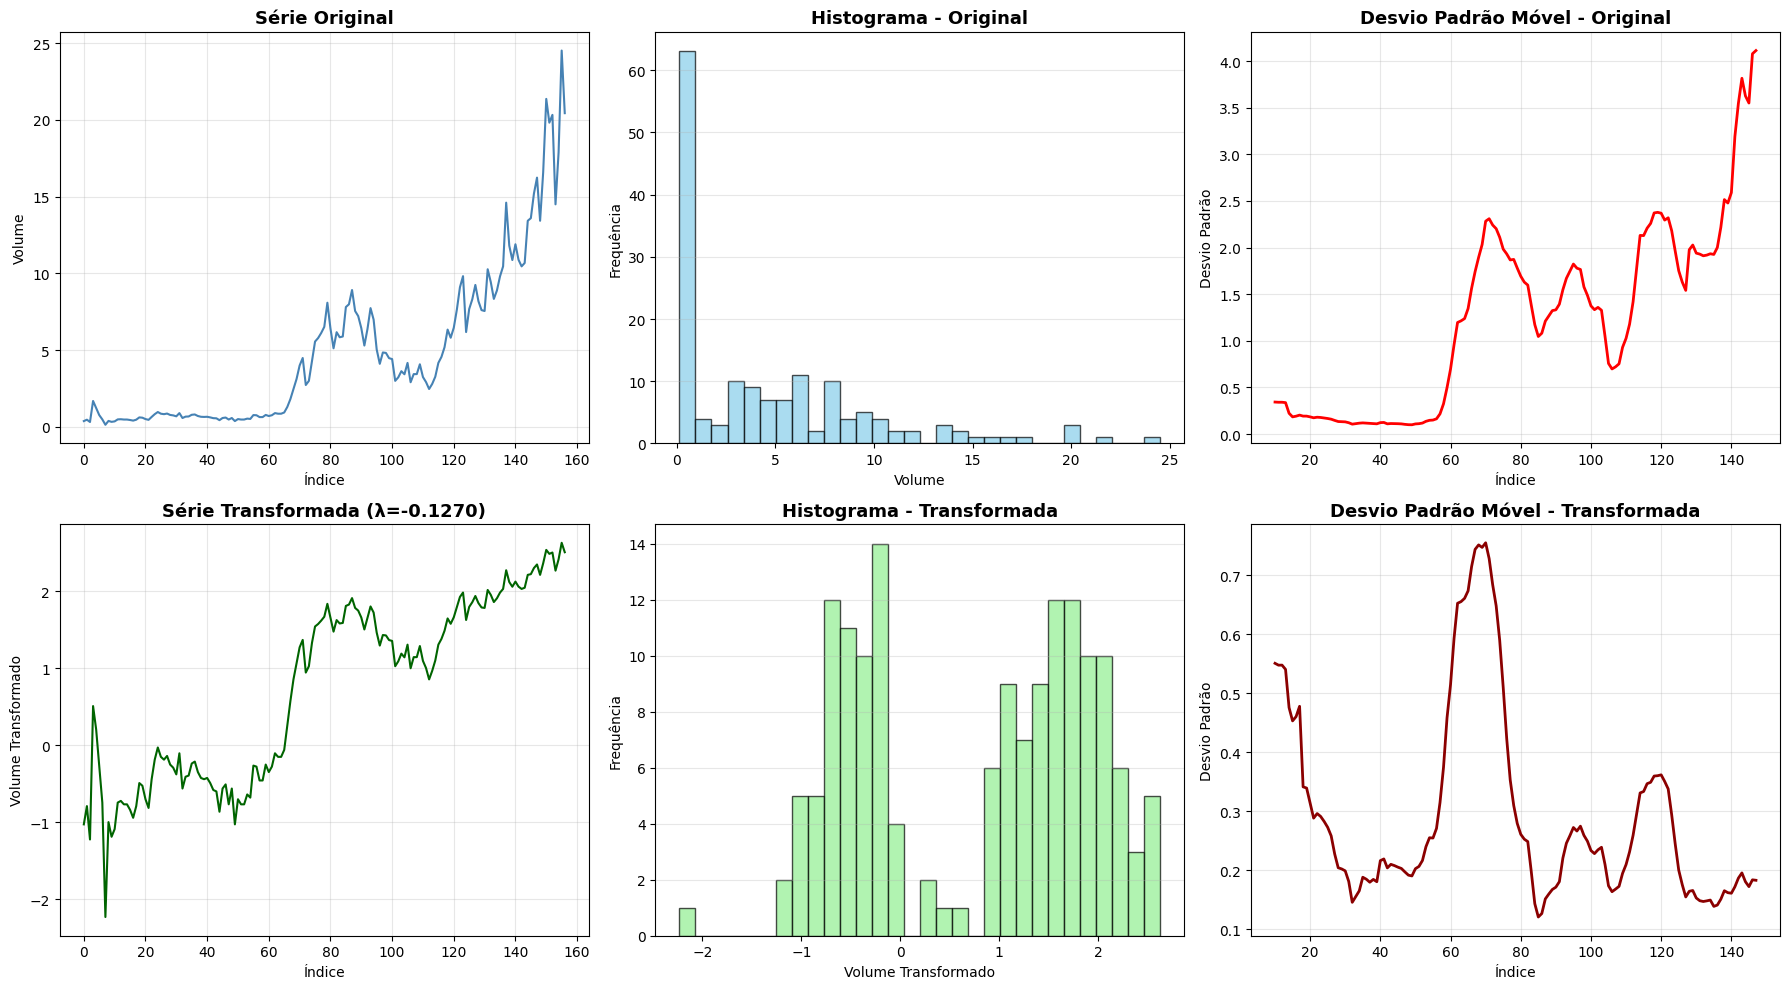


Coeficiente de Variação (CV):
  Original: 1.0709
  Box-Cox:  1.5865
  Redução:  -48.14%


In [834]:
# Comparação visual: antes vs depois da transformação
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Linha 1: Série Original
ax1 = axes[0, 0]
ax1.plot(series.index, series.values, linewidth=1.5, color='steelblue')
ax1.set_title('Série Original', fontsize=13, fontweight='bold')
ax1.set_xlabel('Índice')
ax1.set_ylabel('Volume')
ax1.grid(alpha=0.3)

ax2 = axes[0, 1]
ax2.hist(series.values, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
ax2.set_title('Histograma - Original', fontsize=13, fontweight='bold')
ax2.set_xlabel('Volume')
ax2.set_ylabel('Frequência')
ax2.grid(alpha=0.3, axis='y')

ax3 = axes[0, 2]
rolling_std_original = series.rolling(window=20, center=True).std()
ax3.plot(rolling_std_original.index, rolling_std_original.values, linewidth=2, color='red')
ax3.set_title('Desvio Padrão Móvel - Original', fontsize=13, fontweight='bold')
ax3.set_xlabel('Índice')
ax3.set_ylabel('Desvio Padrão')
ax3.grid(alpha=0.3)

# Linha 2: Série Transformada (Box-Cox)
ax4 = axes[1, 0]
ax4.plot(series_boxcox.index, series_boxcox.values, linewidth=1.5, color='darkgreen')
ax4.set_title(f'Série Transformada (λ={lambda_opt:.4f})', fontsize=13, fontweight='bold')
ax4.set_xlabel('Índice')
ax4.set_ylabel('Volume Transformado')
ax4.grid(alpha=0.3)

ax5 = axes[1, 1]
ax5.hist(series_boxcox.values, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
ax5.set_title('Histograma - Transformada', fontsize=13, fontweight='bold')
ax5.set_xlabel('Volume Transformado')
ax5.set_ylabel('Frequência')
ax5.grid(alpha=0.3, axis='y')

ax6 = axes[1, 2]
rolling_std_boxcox = series_boxcox.rolling(window=20, center=True).std()
ax6.plot(rolling_std_boxcox.index, rolling_std_boxcox.values, linewidth=2, color='darkred')
ax6.set_title('Desvio Padrão Móvel - Transformada', fontsize=13, fontweight='bold')
ax6.set_xlabel('Índice')
ax6.set_ylabel('Desvio Padrão')
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Comparação do CV
cv_original = series.std() / series.mean()
cv_boxcox = series_boxcox.std() / abs(series_boxcox.mean())
print(f"\nCoeficiente de Variação (CV):")
print(f"  Original: {cv_original:.4f}")
print(f"  Box-Cox:  {cv_boxcox:.4f}")
print(f"  Redução:  {((cv_original - cv_boxcox) / cv_original * 100):.2f}%")

### Interpretação - Efeito da Transformação Box-Cox

**Comparação Visual:**
- **Desvio Padrão Móvel**: Deve se tornar mais estável (menos variação) após a transformação
- **Histograma**: Pode se tornar mais simétrico e próximo da normalidade
- **Série Temporal**: Amplitude das flutuações deve ser mais constante

**Coeficiente de Variação (CV):**
- Mede a variabilidade relativa (desvio padrão / média)
- Redução significativa do CV indica estabilização bem-sucedida da variância
- CV menor → variância mais homogênea ao longo do tempo

## 3. Ajuste dos Baselines com Dados Transformados

Agora vamos ajustar os mesmos 5 modelos de baseline, mas usando os dados transformados por Box-Cox. 

**Importante**: 
- As previsões serão feitas na escala transformada
- Após obter as previsões, será necessário **reverter** a transformação Box-Cox para calcular as métricas de erro na escala original
- Isso permite comparação justa com os modelos sem transformação

In [835]:
# Função para reverter a transformação Box-Cox
from scipy.special import inv_boxcox

def inverse_boxcox(y_transformed, lambda_param, shift=0):
    """
    Reverte a transformação Box-Cox
    """
    y_original = inv_boxcox(y_transformed, lambda_param)
    if shift > 0:
        y_original = y_original - shift
    return y_original

# Teste da função
test_value_transformed = series_boxcox.iloc[0]
test_value_original_recovered = inverse_boxcox(test_value_transformed, lambda_opt, shift)
test_value_original_actual = series.iloc[0]

print("Teste de reversão da transformação Box-Cox:")
print(f"  Valor original: {test_value_original_actual:.6f}")
print(f"  Valor recuperado: {test_value_original_recovered:.6f}")
print(f"  Diferença: {abs(test_value_original_actual - test_value_original_recovered):.10f}")
print(f"  ✓ Reversão funcionando corretamente!" if abs(test_value_original_actual - test_value_original_recovered) < 1e-6 else "  ✗ ERRO na reversão!")

Teste de reversão da transformação Box-Cox:
  Valor original: 0.380000
  Valor recuperado: 0.380000
  Diferença: 0.0000000000
  ✓ Reversão funcionando corretamente!


In [836]:
# Ajuste de TODOS os baselines com dados transformados
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Usaremos a série transformada
series_transformed = series_boxcox.copy()

# Dicionário para armazenar resultados de todos os modelos
results_boxcox = {}

print("Ajustando modelos de baseline com dados transformados por Box-Cox...")
print("=" * 70)

# Os mesmos cv_splits definidos anteriormente
for model_name in ["Mean", "Naive", "Seasonal Naive", "Drift", "Rolling Mean"]:
    print(f"\n{model_name}...", end=" ")
    
    rows = []
    for i, (tr_slice, te_slice) in enumerate(cv_splits, start=1):
        train_tr = series_transformed.iloc[tr_slice].reset_index(drop=True)
        test_tr = series_transformed.iloc[te_slice].reset_index(drop=True)
        
        # Valores originais do teste para cálculo de métricas
        test_orig = series.iloc[te_slice].reset_index(drop=True)
        h = len(test_tr)
        
        # One-step-ahead rolling forecast
        preds_tr = []
        for j in range(h):
            if j == 0:
                history_tr = train_tr
            else:
                history_tr = pd.concat([train_tr, test_tr.iloc[:j]], ignore_index=True)
            
            # Previsão dependendo do modelo
            if model_name == "Mean":
                pred = history_tr.mean()
            elif model_name == "Naive":
                pred = history_tr.iloc[-1]
            elif model_name == "Seasonal Naive":
                m = 52
                seasonal_idx = len(history_tr) - m
                pred = history_tr.iloc[seasonal_idx] if seasonal_idx >= 0 else history_tr.iloc[-1]
            elif model_name == "Drift":
                y_T = history_tr.iloc[-1]
                y_1 = history_tr.iloc[0]
                T = len(history_tr)
                C = (y_T - y_1) / (T - 1)
                pred = y_T + C
            elif model_name == "Rolling Mean":
                K = 12
                pred = history_tr.iloc[-K:].mean() if len(history_tr) >= K else history_tr.mean()
            
            preds_tr.append(pred)
        
        # Reverter Box-Cox nas previsões
        preds_tr = np.array(preds_tr)
        preds_orig = inverse_boxcox(preds_tr, lambda_opt, shift)
        
        # Calcular métricas na escala original
        mae = mean_absolute_error(test_orig, preds_orig)
        rmse = np.sqrt(mean_squared_error(test_orig, preds_orig))
        denom = np.where(np.abs(test_orig.values) < 1e-9, 1e-9, test_orig.values)
        mape = np.mean(np.abs((test_orig.values - preds_orig) / denom)) * 100
        
        rows.append({
            "fold": i,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape
        })
    
    results_boxcox[model_name] = pd.DataFrame(rows)
    print("✓")

print("\n" + "=" * 70)
print("Todos os modelos ajustados com sucesso!")

Ajustando modelos de baseline com dados transformados por Box-Cox...

Mean... ✓

Naive... ✓

Seasonal Naive... ✓

Drift... ✓

Rolling Mean... ✓

Todos os modelos ajustados com sucesso!


## 4. Comparação: Com vs Sem Transformação Box-Cox

In [837]:
# Tabela comparativa: SEM vs COM Box-Cox
import pandas as pd

# Resultados SEM Box-Cox (já calculados anteriormente)
results_original = {
    "Mean": res_mean,
    "Naive": res_naive,
    "Seasonal Naive": res_seasonal_naive,
    "Drift": res_drift,
    "Rolling Mean": res_rolling_mean
}

# Criar tabela comparativa
comparison_data = []

for model_name in ["Mean", "Naive", "Seasonal Naive", "Drift", "Rolling Mean"]:
    res_orig = results_original[model_name]
    res_bc = results_boxcox[model_name]
    
    comparison_data.append({
        "Modelo": model_name,
        "MAE_Sem_BoxCox": res_orig["MAE"].mean(),
        "MAE_Com_BoxCox": res_bc["MAE"].mean(),
        "RMSE_Sem_BoxCox": res_orig["RMSE"].mean(),
        "RMSE_Com_BoxCox": res_bc["RMSE"].mean(),
        "MAPE_Sem_BoxCox": res_orig["MAPE"].mean(),
        "MAPE_Com_BoxCox": res_bc["MAPE"].mean()
    })

comparison_table = pd.DataFrame(comparison_data)

# Calcular melhoria percentual
comparison_table["Melhoria_MAE_%"] = ((comparison_table["MAE_Sem_BoxCox"] - comparison_table["MAE_Com_BoxCox"]) / comparison_table["MAE_Sem_BoxCox"] * 100)
comparison_table["Melhoria_RMSE_%"] = ((comparison_table["RMSE_Sem_BoxCox"] - comparison_table["RMSE_Com_BoxCox"]) / comparison_table["RMSE_Sem_BoxCox"] * 100)
comparison_table["Melhoria_MAPE_%"] = ((comparison_table["MAPE_Sem_BoxCox"] - comparison_table["MAPE_Com_BoxCox"]) / comparison_table["MAPE_Sem_BoxCox"] * 100)

print("=" * 100)
print("COMPARAÇÃO: MODELOS SEM vs COM TRANSFORMAÇÃO BOX-COX")
print("=" * 100)
print("\nMétricas (valores menores são melhores):")
display(comparison_table[["Modelo", "MAE_Sem_BoxCox", "MAE_Com_BoxCox", "RMSE_Sem_BoxCox", "RMSE_Com_BoxCox", "MAPE_Sem_BoxCox", "MAPE_Com_BoxCox"]])

print("\n" + "=" * 100)
print("MELHORIA PERCENTUAL (valores positivos = melhoria)")
print("=" * 100)
display(comparison_table[["Modelo", "Melhoria_MAE_%", "Melhoria_RMSE_%", "Melhoria_MAPE_%"]])

# Resumo geral
print("\n" + "=" * 100)
print("RESUMO GERAL:")
print("=" * 100)

avg_improvement_mae = comparison_table["Melhoria_MAE_%"].mean()
avg_improvement_rmse = comparison_table["Melhoria_RMSE_%"].mean()
avg_improvement_mape = comparison_table["Melhoria_MAPE_%"].mean()

print(f"\nMelhoria média com Box-Cox:")
print(f"  MAE:  {avg_improvement_mae:+.2f}%")
print(f"  RMSE: {avg_improvement_rmse:+.2f}%")
print(f"  MAPE: {avg_improvement_mape:+.2f}%")

if avg_improvement_mae > 0:
    print(f"\n✓ Em média, a transformação Box-Cox MELHOROU as previsões")
else:
    print(f"\n⚠ Em média, a transformação Box-Cox NÃO melhorou as previsões")

print("=" * 100)

COMPARAÇÃO: MODELOS SEM vs COM TRANSFORMAÇÃO BOX-COX

Métricas (valores menores são melhores):


,Modelo,MAE_Sem_BoxCox,MAE_Com_BoxCox,RMSE_Sem_BoxCox,RMSE_Com_BoxCox,MAPE_Sem_BoxCox,MAPE_Com_BoxCox
0,Mean,8.655486,10.343539,8.793149,10.460608,69.886653,84.535586
1,Naive,1.747206,1.747206,2.053144,2.053144,14.308747,14.308747
2,Seasonal Naive,6.507206,6.507206,6.658787,6.658787,49.048764,49.048764
3,Drift,1.734616,1.728640,2.047200,2.061755,14.255857,14.355339
4,Rolling Mean,2.480043,2.654997,2.904220,3.078735,18.886862,20.543009



MELHORIA PERCENTUAL (valores positivos = melhoria)


,Modelo,Melhoria_MAE_%,Melhoria_RMSE_%,Melhoria_MAPE_%
0,Mean,-1.950270e+01,-1.896316e+01,-2.096099e+01
1,Naive,-6.354277e-14,-6.488915e-14,-6.207241e-14
2,Seasonal Naive,0.000000e+00,0.000000e+00,1.448646e-14
3,Drift,3.445085e-01,-7.109396e-01,-6.978278e-01
4,Rolling Mean,-7.054489e+00,-6.009004e+00,-8.768777e+00



RESUMO GERAL:

Melhoria média com Box-Cox:
  MAE:  -5.24%
  RMSE: -5.14%
  MAPE: -6.09%

⚠ Em média, a transformação Box-Cox NÃO melhorou as previsões


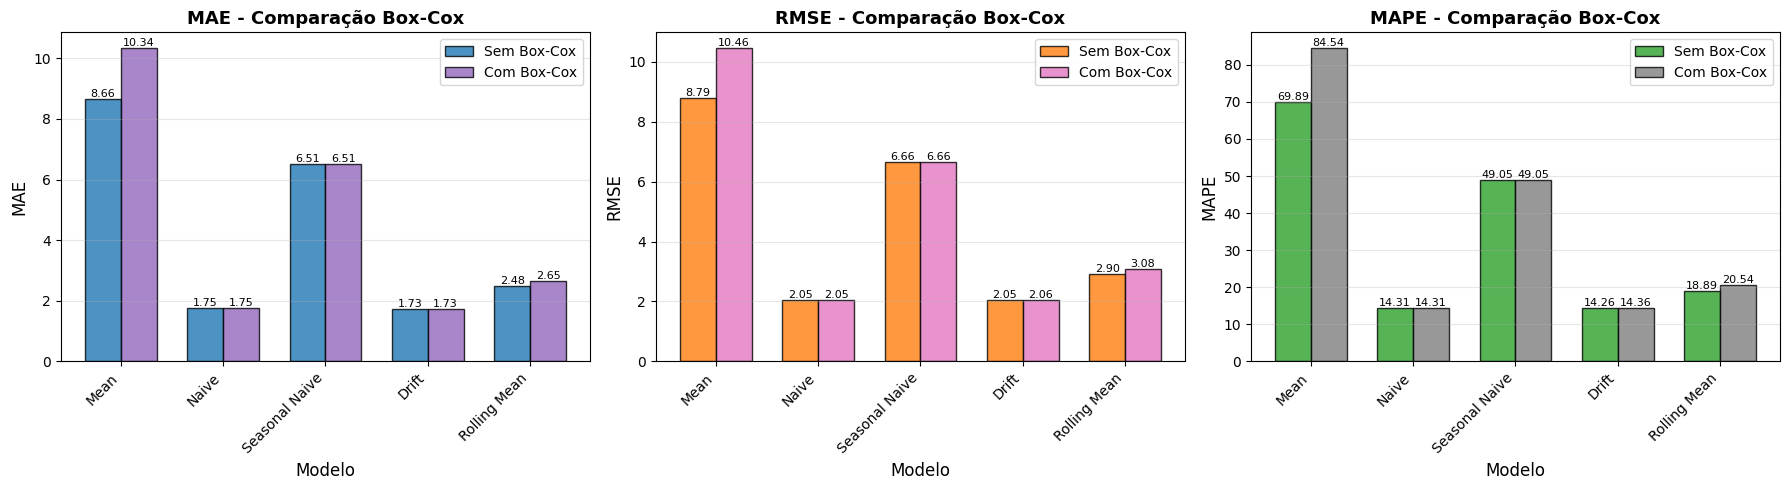

In [838]:
# Gráfico comparativo
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = comparison_table["Modelo"]
x = np.arange(len(models))
width = 0.35

metrics = ["MAE", "RMSE", "MAPE"]
colors_sem = ['#1f77b4', '#ff7f0e', '#2ca02c']
colors_com = ['#9467bd', '#e377c2', '#7f7f7f']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    sem_boxcox = comparison_table[f"{metric}_Sem_BoxCox"]
    com_boxcox = comparison_table[f"{metric}_Com_BoxCox"]
    
    bars1 = ax.bar(x - width/2, sem_boxcox, width, label='Sem Box-Cox', 
                   color=colors_sem[idx], alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, com_boxcox, width, label='Com Box-Cox', 
                   color=colors_com[idx], alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Modelo', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} - Comparação Box-Cox', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.grid(alpha=0.3, axis='y')
    
    # Adiciona valores
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()